# Canada mapping file

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import cascaded_union

from geopandas.tools import sjoin, overlay

from zipfile import ZipFile
import itertools

#import geojson
import json
import copy
from math import ceil

#  Table of content

[Burned area Polygons](#Get-list-of-polygons-For-Burned-area-in-Canada)  
[Canada provinces map](#Canada-province-boundaries)  
[CRS conversion](#convert-polygon-crs-and-province-crs-to-ESRI-102002)  
[Data filtering](#How-many-cells-do-not-have-fire-start-and-end-date)  
[Polygon filtering](#Intersection-between-Canada-and-Burned-polygons)  
[Data exploration](#Explore-data)  
[Group polygons by month](#Group-polygons-by-Month)  
[Save polygons by month (shp)](#Save-polygons-by-month-as-shape-file)  
[Combine polygons](#Combining-sets-based-on-proximity)   
- [Functions](#Functions)  
- [Set1:](#Set1:)  
- [Set2:](#Set2:)  
- [Set3:](#Set3:)  
- [Set4:](#Set4:)  
- [Set5:](#Set5:)     

[Download dates](#Download-dates)   
[Suitable figures](#Suitable-figures)

# Get list of polygons For Burned area in Canada

In [2]:
# Designate the local filename
local_file_name = 'nbac_2019_r9_20210810.zip'

# unzip file
to_unzip = ZipFile(local_file_name, 'r')
unzipped = 'Canada/'
to_unzip.extractall(unzipped)
to_unzip.close()


In [3]:
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file

In [4]:
# Read data into GeoDataFrame and view the data
canada_fire = gpd.GeoDataFrame.from_file(shape_file)
canada_fire.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-294305.000 1166255.125, -2943..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-751637.125 1395075.000, -751629.875..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-1012537.938 1322208.000, -1012528.1..."
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,2019-08-20,None,135.032014,135.032014,0.0,QC,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2006518.386 762885.450, 200652..."
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,2019-08-20,None,66.315530,66.315530,0.0,QC,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((1965912.797 665911.512, 1965912.657 ..."


In [5]:
canada_fire.columns

Index(['YEAR', 'NFIREID', 'BASRC', 'FIREMAPS', 'FIREMAPM', 'FIRECAUS',
       'BURNCLAS', 'SDATE', 'EDATE', 'AFSDATE', 'AFEDATE', 'CAPDATE',
       'POLY_HA', 'ADJ_HA', 'ADJ_FLAG', 'AGENCY', 'BT_GID', 'VERSION',
       'COMMENTS', 'geometry'],
      dtype='object')

In [6]:
canada_fire.crs

<Projected CRS: PROJCS["Canada_Lambert_Conformal_Conic",GEOGCS["NA ...>
Name: Canada_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
burned_area = canada_fire['ADJ_HA'].sum()
print('burned area {:.2f}'.format(burned_area))

burned area 1603878.94


# Canada province boundaries

In [8]:
# Designate the local filename
local_file_name2 = 'lpr_000b16a_e.zip'

# unzip file
to_unzip2 = ZipFile(local_file_name2, 'r')
unzipped2 = 'Canada_provinces/'
to_unzip2.extractall(unzipped2)
to_unzip2.close()


In [9]:
for file2 in os.listdir(unzipped2):
    if file2.endswith(".shp"):
        shape_file2 =  unzipped2 + file2
shape_file2

'Canada_provinces/lpr_000b16a_e.shp'

In [10]:
# Read data into GeoDataFrame and view the data
canada_provinces = gpd.GeoDataFrame.from_file(shape_file2)
canada_provinces

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."
5,35,Ontario,Ontario,Ontario,Ont.,Ont.,"MULTIPOLYGON (((6378815.614 2295412.440, 63787..."
6,46,Manitoba,Manitoba,Manitoba,Man.,Man.,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
7,47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,"POLYGON ((5248633.914 2767057.263, 5249285.640..."
8,48,Alberta,Alberta,Alberta,Alta.,Alb.,"POLYGON ((5228304.177 2767597.891, 5228098.463..."
9,59,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,"MULTIPOLYGON (((4018904.414 3410247.271, 40194..."


In [11]:
canada_provinces.crs

<Projected CRS: PROJCS["PCS_Lambert_Conformal_Conic",GEOGCS["NAD83 ...>
Name: PCS_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
canada_provinces.columns

Index(['PRUID', 'PRNAME', 'PRENAME', 'PRFNAME', 'PREABBR', 'PRFABBR',
       'geometry'],
      dtype='object')

<AxesSubplot:>

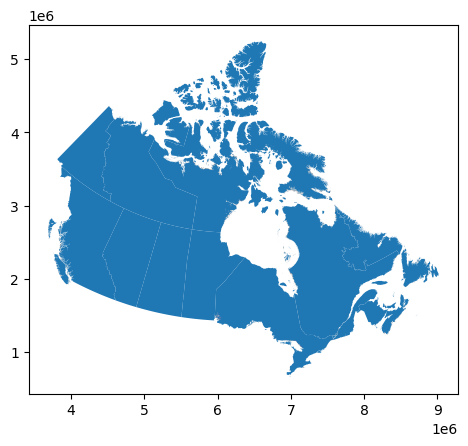

In [13]:
canada_provinces.plot()
#plt.savefig('Canada_provinces.png')
#plt.close()

# convert polygon crs and province crs to ESRI 102002

## convert polygon crs to ESRI 102002

In [14]:
canada_fire_ESRI102002 = canada_fire.to_crs('ESRI:102002')

In [15]:
canada_fire_ESRI102002.crs

<Projected CRS: ESRI:102002>
Name: Canada_Lambert_Conformal_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Canada_Lambert_Conformal_Conic
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
for idx in list(range(len(canada_fire_ESRI102002['geometry']))):
    pol = canada_fire_ESRI102002['geometry'][idx]
    if pol.is_valid:
        continue
    else:
        print(idx)

## convert Canada crs to ESRI 102002

In [17]:
Gdf_canada_provinces_ESRI102002 = canada_provinces.to_crs('ESRI:102002')

In [18]:
Gdf_canada_provinces_ESRI102002.crs

<Projected CRS: ESRI:102002>
Name: Canada_Lambert_Conformal_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Canada_Lambert_Conformal_Conic
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
Gdf_canada_provinces_ESRI102002

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((2357107.760 2302804.144, 23581..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((2527439.762 1403810.494, 25275..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((2565164.728 1350293.249, 25653..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((2265822.751 1434024.250, 22658..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((2464426.893 1984681.359, 24653..."
5,35,Ontario,Ontario,Ontario,Ont.,Ont.,"MULTIPOLYGON (((428650.873 1911223.286, 428667..."
6,46,Manitoba,Manitoba,Manitoba,Man.,Man.,"MULTIPOLYGON (((64659.213 2233832.514, 64629.7..."
7,47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,"POLYGON ((-743986.232 2311335.386, -743314.061..."
8,48,Alberta,Alberta,Alberta,Alta.,Alb.,"POLYGON ((-764566.901 2310394.744, -764723.342..."
9,59,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,"MULTIPOLYGON (((-2037876.596 2862898.644, -203..."


In [20]:
Gdf_canada_provinces_ESRI102002['geometry'][8].is_valid

True

## How many cells do not have fire start and end date

In [21]:
fire_start = canada_fire_ESRI102002['SDATE']
len(fire_start)

892

In [22]:
fire_end = canada_fire_ESRI102002['EDATE']
len(fire_end)

892

In [23]:
print('Number of None value in SDATE column {}'.format(fire_start.isna().sum()))

Number of None value in SDATE column 569


In [24]:
print('Number of None value in EDATE column {}'.format(fire_end.isna().sum()))

Number of None value in EDATE column 569


In [25]:
filt = (canada_fire_ESRI102002['SDATE'].isna())
filt

0      False
1      False
2      False
3      False
4      False
       ...  
887    False
888    False
889    False
890     True
891     True
Name: SDATE, Length: 892, dtype: bool

In [26]:
canada_fire_ESRI102002_filtered = canada_fire_ESRI102002[-filt]
len(canada_fire_ESRI102002_filtered)

323

In [27]:
canada_fire_ESRI102002_filtered

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434..."
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,2019-08-20,None,135.032014,135.032014,0.0,QC,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2083423.726 1802154.140, 20834..."
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,2019-08-20,None,66.315530,66.315530,0.0,QC,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((2042581.681 1704737.457, 2042581.541..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2019.0,1524.0,3.0,0.0,0.0,2.0,4.0,2019-07-31,2019-07-31,None,None,None,195.438947,172.920438,2.0,ON,280.0,2019_r9_20210810,"RED57[TYPE_C:IFR,WEATH_IND:7.1,RESP_OBJ_C:MON,...","POLYGON ((197702.833 1518129.697, 197706.145 1..."
886,2019.0,1523.0,3.0,0.0,0.0,2.0,4.0,2019-07-28,2019-07-28,None,None,None,85.614001,78.200907,2.0,ON,580.0,2019_r9_20210810,"SLK41[TYPE_C:IFR,WEATH_IND:8.9,RESP_OBJ_C:MON,...","POLYGON ((374152.667 1509676.181, 374178.378 1..."
887,2019.0,965.0,3.0,0.0,0.0,3.0,4.0,2019-06-07,2019-07-09,None,None,None,4628.442729,3624.403928,2.0,ON,491.0,2019_r9_20210810,"TIM2[TYPE_C:IFR,WEATH_IND:15.5,RESP_OBJ_C:FUL,...","POLYGON ((1061928.049 1002747.517, 1061916.921..."
888,2019.0,626.0,3.0,0.0,0.0,2.0,4.0,2019-07-27,2019-08-01,None,None,None,226.368077,199.153733,2.0,ON,638.0,2019_r9_20210810,"SLK40[TYPE_C:IFR,WEATH_IND:17.4,RESP_OBJ_C:MON...","MULTIPOLYGON (((254681.758 1499653.144, 254565..."


In [28]:
canada_fire_ESRI102002_discrarded = canada_fire_ESRI102002[filt]
len(canada_fire_ESRI102002_discrarded)

569

In [29]:
canada_fire_ESRI102002_discrarded.crs

<Projected CRS: ESRI:102002>
Name: Canada_Lambert_Conformal_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Canada_Lambert_Conformal_Conic
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
burned_area_total     = canada_fire_ESRI102002['ADJ_HA'].sum()
burned_area_filtered  = canada_fire_ESRI102002_filtered['ADJ_HA'].sum()
burned_area_discarded = canada_fire_ESRI102002_discrarded['ADJ_HA'].sum()

In [31]:
print('burned area total     {:10.2f} percentage {:6.2f}%'.format(burned_area_total,100))
print('burned area filtered  {:10.2f} percentage {:6.2f}%'.format(burned_area_filtered,(burned_area_filtered/burned_area_total)*100))
print('burned area discarded {:10.2f} percentage {:6.2f}%'.format(burned_area_discarded,(burned_area_discarded/burned_area_total)*100))

burned area total     1603878.94 percentage 100.00%
burned area filtered  1582393.65 percentage  98.66%
burned area discarded   21485.29 percentage   1.34%


In [32]:
geom = canada_fire_ESRI102002_filtered['geometry']

In [33]:
poly_area = geom.area
poly_area = poly_area/10000

<AxesSubplot:title={'center':'histogram of polygon areas in Ha'}, ylabel='Frequency'>

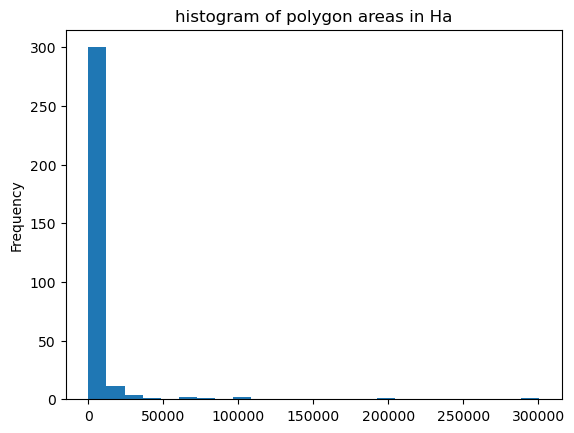

In [34]:
poly_area.plot.hist(bins=25,title ='histogram of polygon areas in Ha',xlabel='polygon area in Ha')

In [35]:
canada_fire_ESRI102002_filtered = canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=64]
canada_fire_ESRI102002_filtered

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434..."
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,2019-08-20,None,135.032014,135.032014,0.0,QC,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2083423.726 1802154.140, 20834..."
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,2019-08-20,None,66.315530,66.315530,0.0,QC,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((2042581.681 1704737.457, 2042581.541..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2019.0,1524.0,3.0,0.0,0.0,2.0,4.0,2019-07-31,2019-07-31,None,None,None,195.438947,172.920438,2.0,ON,280.0,2019_r9_20210810,"RED57[TYPE_C:IFR,WEATH_IND:7.1,RESP_OBJ_C:MON,...","POLYGON ((197702.833 1518129.697, 197706.145 1..."
886,2019.0,1523.0,3.0,0.0,0.0,2.0,4.0,2019-07-28,2019-07-28,None,None,None,85.614001,78.200907,2.0,ON,580.0,2019_r9_20210810,"SLK41[TYPE_C:IFR,WEATH_IND:8.9,RESP_OBJ_C:MON,...","POLYGON ((374152.667 1509676.181, 374178.378 1..."
887,2019.0,965.0,3.0,0.0,0.0,3.0,4.0,2019-06-07,2019-07-09,None,None,None,4628.442729,3624.403928,2.0,ON,491.0,2019_r9_20210810,"TIM2[TYPE_C:IFR,WEATH_IND:15.5,RESP_OBJ_C:FUL,...","POLYGON ((1061928.049 1002747.517, 1061916.921..."
888,2019.0,626.0,3.0,0.0,0.0,2.0,4.0,2019-07-27,2019-08-01,None,None,None,226.368077,199.153733,2.0,ON,638.0,2019_r9_20210810,"SLK40[TYPE_C:IFR,WEATH_IND:17.4,RESP_OBJ_C:MON...","MULTIPOLYGON (((254681.758 1499653.144, 254565..."


In [36]:
canada_fire_ESRI102002_filtered.iloc[1]

YEAR                                                   2019.0
NFIREID                                                 131.0
BASRC                                                     1.0
FIREMAPS                                                  9.0
FIREMAPM                                                  7.0
FIRECAUS                                                  2.0
BURNCLAS                                                  4.0
SDATE                                              2019-07-21
EDATE                                              2019-08-01
AFSDATE                                            2019-07-22
AFEDATE                                                  None
CAPDATE                                            2019-09-10
POLY_HA                                           1875.667591
ADJ_HA                                            1875.667591
ADJ_FLAG                                                  0.0
AGENCY                                                     NT
BT_GID  

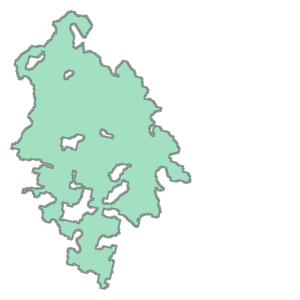

In [37]:
canada_fire_ESRI102002_filtered.iloc[1]['geometry']

In [38]:
canada_fire_ESRI102002_filtered.iloc[1]['geometry'].area/10000

1818.7000698953393

In [39]:
poly_area.min()

0.35291481314563594

In [40]:
poly_area.max()

300752.7508207258

In [41]:
poly_area.describe()

count       323.000000
mean       4888.403047
std       22657.246813
min           0.352915
25%          45.002132
50%         344.455748
75%        1825.456366
max      300752.750821
dtype: float64

## Load filtered polygons

In [48]:
poly_intersection = copy.copy(canada_fire_ESRI102002_filtered)
poly_intersection.reset_index(inplace=True,drop=True) 
poly_intersection

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434..."
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,2019-08-20,None,135.032014,135.032014,0.0,QC,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2083423.726 1802154.140, 20834..."
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,2019-08-20,None,66.315530,66.315530,0.0,QC,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((2042581.681 1704737.457, 2042581.541..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2019.0,1524.0,3.0,0.0,0.0,2.0,4.0,2019-07-31,2019-07-31,None,None,None,195.438947,172.920438,2.0,ON,280.0,2019_r9_20210810,"RED57[TYPE_C:IFR,WEATH_IND:7.1,RESP_OBJ_C:MON,...","POLYGON ((197702.833 1518129.697, 197706.145 1..."
227,2019.0,1523.0,3.0,0.0,0.0,2.0,4.0,2019-07-28,2019-07-28,None,None,None,85.614001,78.200907,2.0,ON,580.0,2019_r9_20210810,"SLK41[TYPE_C:IFR,WEATH_IND:8.9,RESP_OBJ_C:MON,...","POLYGON ((374152.667 1509676.181, 374178.378 1..."
228,2019.0,965.0,3.0,0.0,0.0,3.0,4.0,2019-06-07,2019-07-09,None,None,None,4628.442729,3624.403928,2.0,ON,491.0,2019_r9_20210810,"TIM2[TYPE_C:IFR,WEATH_IND:15.5,RESP_OBJ_C:FUL,...","POLYGON ((1061928.049 1002747.517, 1061916.921..."
229,2019.0,626.0,3.0,0.0,0.0,2.0,4.0,2019-07-27,2019-08-01,None,None,None,226.368077,199.153733,2.0,ON,638.0,2019_r9_20210810,"SLK40[TYPE_C:IFR,WEATH_IND:17.4,RESP_OBJ_C:MON...","MULTIPOLYGON (((254681.758 1499653.144, 254565..."


In [49]:
print('the number of polygons after filtering is: {}'.format(len(poly_intersection)))

the number of polygons after filtering is: 231


In [120]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_intersection.plot(ax=base, color='red')
'''
plt.savefig('Canada_fire_2019.png')
plt.close()
'''

In [51]:
poly_intersection['geometry'].type.unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

# Explore data

In [52]:
canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=100000]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
7,2019.0,30.0,1.0,9.0,7.0,2.0,4.0,2019-05-22,2019-09-13,2019-05-23,None,2019-09-06,109803.566598,109803.566598,0.0,YT,116.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1934890.458 3274629.401, -193..."
32,2019.0,382.0,3.0,4.0,2.0,0.0,4.0,2019-05-18,2019-07-21,2019-05-18,None,2019-07-23,199888.004745,199888.004745,0.0,AB,341.0,2019_r9_20210810,"SWF-049-2019[alias:McMillan Complex Fire,BURNC...","MULTIPOLYGON (((-1129885.365 1904547.797, -112..."
35,2019.0,172.0,3.0,4.0,2.0,0.0,4.0,2019-05-12,2019-09-13,2019-05-12,None,2019-10-03,309709.626567,309709.626567,0.0,AB,627.0,2019_r9_20210810,"HWF-042-2019[alias:Chuckegg Creek Fire,BURNCOD...","MULTIPOLYGON (((-1230067.947 2295091.063, -123..."


In [53]:
canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=50000]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
7,2019.0,30.0,1.0,9.0,7.0,2.0,4.0,2019-05-22,2019-09-13,2019-05-23,None,2019-09-06,109803.566598,109803.566598,0.0,YT,116.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1934890.458 3274629.401, -193..."
32,2019.0,382.0,3.0,4.0,2.0,0.0,4.0,2019-05-18,2019-07-21,2019-05-18,None,2019-07-23,199888.004745,199888.004745,0.0,AB,341.0,2019_r9_20210810,"SWF-049-2019[alias:McMillan Complex Fire,BURNC...","MULTIPOLYGON (((-1129885.365 1904547.797, -112..."
35,2019.0,172.0,3.0,4.0,2.0,0.0,4.0,2019-05-12,2019-09-13,2019-05-12,None,2019-10-03,309709.626567,309709.626567,0.0,AB,627.0,2019_r9_20210810,"HWF-042-2019[alias:Chuckegg Creek Fire,BURNCOD...","MULTIPOLYGON (((-1230067.947 2295091.063, -123..."
69,2019.0,177.0,1.0,9.0,7.0,0.0,4.0,2019-05-19,2019-07-27,None,None,2019-07-15,80620.723137,80620.723137,0.0,PC-WB,184.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-906640.481 2280091.425, -9066..."
118,2019.0,8.0,1.0,9.0,7.0,2.0,4.0,2019-07-23,2019-08-02,2019-07-24,None,2019-09-02,61984.495430,61984.495430,0.0,NT,28.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1457847.107 3449607.690, -145..."
124,2019.0,645.0,3.0,0.0,0.0,2.0,4.0,2019-06-15,2019-07-14,None,None,None,97956.832188,68184.684435,2.0,ON,853.0,2019_r9_20210810,"RED23[TYPE_C:IFR,WEATH_IND:5.5,RESP_OBJ_C:MON,...","MULTIPOLYGON (((194483.236 1434014.159, 194315..."
180,2019.0,133.0,3.0,4.0,2.0,0.0,4.0,2019-05-27,2019-07-11,2019-05-27,None,2019-09-09,63381.003760,63381.003760,0.0,AB,609.0,2019_r9_20210810,"HWF-066-2019[alias:Jackpot Creek Fire,BURNCODE...","MULTIPOLYGON (((-1127081.746 2397851.442, -112..."


In [54]:
canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=10000]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
7,2019.0,30.0,1.0,9.0,7.0,2.0,4.0,2019-05-22,2019-09-13,2019-05-23,None,2019-09-06,109803.566598,109803.566598,0.0,YT,116.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1934890.458 3274629.401, -193..."
8,2019.0,673.0,1.0,9.0,7.0,2.0,4.0,2019-06-16,2019-07-14,None,None,2020-05-12,16518.554374,16518.554374,0.0,ON,6.0,2019_r9_20210810,Null,"MULTIPOLYGON (((111997.417 1404472.812, 112055..."
15,2019.0,255.0,3.0,10.0,4.0,2.0,4.0,2019-07-17,2019-07-25,2019-07-17,None,2019-09-10,24044.951035,24044.951035,0.0,AB,323.0,2019_r9_20210810,"MWF-051-2019[alias:Old Fort Complex Fire,BURNC...","MULTIPOLYGON (((-802259.114 2185448.364, -8022..."
30,2019.0,49.0,1.0,9.0,7.0,0.0,4.0,2019-06-30,2019-09-13,None,None,2019-09-08,25943.833096,25943.833096,0.0,YT,139.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1775085.016 3183043.375, -177..."
32,2019.0,382.0,3.0,4.0,2.0,0.0,4.0,2019-05-18,2019-07-21,2019-05-18,None,2019-07-23,199888.004745,199888.004745,0.0,AB,341.0,2019_r9_20210810,"SWF-049-2019[alias:McMillan Complex Fire,BURNC...","MULTIPOLYGON (((-1129885.365 1904547.797, -112..."
35,2019.0,172.0,3.0,4.0,2.0,0.0,4.0,2019-05-12,2019-09-13,2019-05-12,None,2019-10-03,309709.626567,309709.626567,0.0,AB,627.0,2019_r9_20210810,"HWF-042-2019[alias:Chuckegg Creek Fire,BURNCOD...","MULTIPOLYGON (((-1230067.947 2295091.063, -123..."
41,2019.0,94.0,1.0,9.0,7.0,2.0,4.0,2019-05-28,2019-06-13,2019-05-27,None,2019-08-29,12026.378457,12026.378457,0.0,YT,99.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1593315.081 2629775.008, -159..."
64,2019.0,70.0,1.0,9.0,7.0,2.0,4.0,2019-06-24,2019-09-11,2019-06-24,None,2019-08-18,12626.535317,12626.535317,0.0,YT,195.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1686946.024 2960525.409, -168..."
67,2019.0,748.0,1.0,9.0,7.0,2.0,4.0,2019-07-03,2019-07-08,None,None,2020-05-12,33353.457146,33353.457146,0.0,ON,171.0,2019_r9_20210810,Null,"MULTIPOLYGON (((78304.128 1313139.732, 78302.8..."
68,2019.0,603.0,1.0,9.0,7.0,2.0,4.0,2019-06-14,2019-08-02,None,2019-08-28,2019-08-12,22445.800164,22445.800164,0.0,MB,122.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-10570.700 1522579.351, -10540..."


In [55]:
canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=5000]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
7,2019.0,30.0,1.0,9.0,7.0,2.0,4.0,2019-05-22,2019-09-13,2019-05-23,None,2019-09-06,109803.566598,109803.566598,0.0,YT,116.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1934890.458 3274629.401, -193..."
8,2019.0,673.0,1.0,9.0,7.0,2.0,4.0,2019-06-16,2019-07-14,None,None,2020-05-12,16518.554374,16518.554374,0.0,ON,6.0,2019_r9_20210810,Null,"MULTIPOLYGON (((111997.417 1404472.812, 112055..."
9,2019.0,67.0,1.0,9.0,7.0,2.0,4.0,2019-06-30,2019-07-11,2019-07-01,None,2019-09-08,6188.611526,6188.611526,0.0,YT,20.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1883465.039 3005562.241, -188..."
15,2019.0,255.0,3.0,10.0,4.0,2.0,4.0,2019-07-17,2019-07-25,2019-07-17,None,2019-09-10,24044.951035,24044.951035,0.0,AB,323.0,2019_r9_20210810,"MWF-051-2019[alias:Old Fort Complex Fire,BURNC...","MULTIPOLYGON (((-802259.114 2185448.364, -8022..."
21,2019.0,105.0,3.0,6.0,4.0,2.0,4.0,2019-05-26,2019-05-31,2019-05-26,None,2019-06-14,5602.007157,5602.007157,0.0,BC,709.0,2019_r9_20210810,G90363[SOURCE:2019 ROLLOVER],"POLYGON ((-1509386.524 2550156.675, -1509354.7..."
29,2019.0,734.0,1.0,9.0,7.0,2.0,4.0,2019-07-01,2019-07-08,None,None,2020-05-12,8392.844940,8392.844940,0.0,ON,132.0,2019_r9_20210810,Null,"POLYGON ((72766.264 1331469.929, 72767.539 133..."
30,2019.0,49.0,1.0,9.0,7.0,0.0,4.0,2019-06-30,2019-09-13,None,None,2019-09-08,25943.833096,25943.833096,0.0,YT,139.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1775085.016 3183043.375, -177..."
32,2019.0,382.0,3.0,4.0,2.0,0.0,4.0,2019-05-18,2019-07-21,2019-05-18,None,2019-07-23,199888.004745,199888.004745,0.0,AB,341.0,2019_r9_20210810,"SWF-049-2019[alias:McMillan Complex Fire,BURNC...","MULTIPOLYGON (((-1129885.365 1904547.797, -112..."
35,2019.0,172.0,3.0,4.0,2.0,0.0,4.0,2019-05-12,2019-09-13,2019-05-12,None,2019-10-03,309709.626567,309709.626567,0.0,AB,627.0,2019_r9_20210810,"HWF-042-2019[alias:Chuckegg Creek Fire,BURNCOD...","MULTIPOLYGON (((-1230067.947 2295091.063, -123..."
41,2019.0,94.0,1.0,9.0,7.0,2.0,4.0,2019-05-28,2019-06-13,2019-05-27,None,2019-08-29,12026.378457,12026.378457,0.0,YT,99.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1593315.081 2629775.008, -159..."


In [56]:
canada_fire_ESRI102002_filtered[canada_fire_ESRI102002_filtered['ADJ_HA']>=1000]

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434..."
5,2019.0,291.0,3.0,10.0,2.0,2.0,4.0,2019-07-18,2019-07-23,2019-07-19,2019-08-05,2019-08-21,4418.543505,4418.543505,0.0,SK,823.0,2019_r9_20210810,19SR-OBST[comments:updated via LandSat 8 L1C_T...,"POLYGON ((-413531.659 2139532.960, -413480.357..."
7,2019.0,30.0,1.0,9.0,7.0,2.0,4.0,2019-05-22,2019-09-13,2019-05-23,None,2019-09-06,109803.566598,109803.566598,0.0,YT,116.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-1934890.458 3274629.401, -193..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,2019.0,101.0,3.0,0.0,2.0,2.0,4.0,2019-08-03,2019-08-16,2019-08-04,None,2019-09-11,5445.340591,4914.416442,2.0,BC,405.0,2019_r9_20210810,R91233[SOURCE:2019 ROLLOVER],"POLYGON ((-1999317.048 2564206.486, -1999050.9..."
638,2019.0,1292.0,3.0,3.0,3.0,1.0,4.0,2019-05-01,2019-05-21,None,2019-07-14,2019-04-26,1100.215317,1056.147068,2.0,MB,499.0,2019_r9_20210810,"MB2019CE004[notes:,datasource:GPS - rotary win...","MULTIPOLYGON (((-184600.855 1308607.865, -1845..."
702,2019.0,733.0,3.0,0.0,0.0,4.0,4.0,2019-05-29,2019-06-28,None,None,None,3877.640025,3057.279846,2.0,ON,331.0,2019_r9_20210810,"RED14[TYPE_C:IFR,WEATH_IND:20.4,RESP_OBJ_C:FUL...","MULTIPOLYGON (((146955.058 1333381.473, 146935..."
719,2019.0,80.0,3.0,3.0,3.0,2.0,4.0,2019-08-03,2019-08-13,2019-07-06,None,2019-08-19,1197.052458,1145.371247,2.0,BC,403.0,2019_r9_20210810,R90881[SOURCE:2019 ROLLOVER],"POLYGON ((-2018771.105 2782276.319, -2018784.7..."


### number of None cells in EDATE column

In [57]:
print('Number of None value {}'.format(poly_intersection['EDATE'].isna().sum()))

Number of None value 0


### convert date cells from string to date

In [58]:
Sdate_new = pd.to_datetime(poly_intersection['SDATE'],format='%Y-%m-%d')

In [59]:
Sdate_new[0]

Timestamp('2019-07-22 00:00:00')

In [60]:
Edate_new = pd.to_datetime(poly_intersection['EDATE'],format='%Y-%m-%d')

In [61]:
Edate_new[0]

Timestamp('2019-07-26 00:00:00')

### compute fire periods in days

In [62]:
Fire_days = Edate_new-Sdate_new
Fire_days

0      4 days
1     11 days
2      6 days
3      0 days
4      0 days
        ...  
226    0 days
227    0 days
228   32 days
229    5 days
230    1 days
Length: 231, dtype: timedelta64[ns]

In [63]:
Fire_days.dt.days

0       4
1      11
2       6
3       0
4       0
       ..
226     0
227     0
228    32
229     5
230     1
Length: 231, dtype: int64

In [64]:
bins=[0,7,14,21,30,35,42,49,56,63,70,100,125,150]

<AxesSubplot:title={'center':'fire period of each polyogn'}, ylabel='Frequency'>

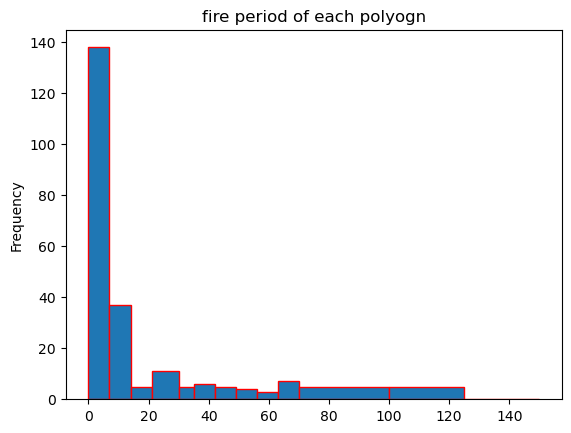

In [65]:
Fire_days.dt.days.plot.hist(bins=bins,title='fire period of each polyogn',edgecolor='red')

In [66]:
dict1 = {'Fire_days':Fire_days}
Fire_days_pd = pd.DataFrame(dict1)

# Find best date for download (one month after fire ended)

- The DOWNLOAD start date is set to 5 days after the fire ended **start_gap**
- The DOWNLOAD end date is set with respect to DOWNLOAD start date: +30, +60, +90 **download_period**

In [67]:
start_gap = 5
download_period = 30

In [68]:
Download_date_start = Edate_new+pd.to_timedelta(start_gap,unit='D')

In [69]:
Download_date_start

0     2019-07-31
1     2019-08-06
2     2019-07-30
3     2019-08-02
4     2019-08-03
         ...    
226   2019-08-05
227   2019-08-02
228   2019-07-14
229   2019-08-06
230   2019-08-09
Name: EDATE, Length: 231, dtype: datetime64[ns]

In [70]:
Download_date_end = Edate_new+pd.to_timedelta(download_period,unit='D')

In [71]:
Download_date_end

0     2019-08-25
1     2019-08-31
2     2019-08-24
3     2019-08-27
4     2019-08-28
         ...    
226   2019-08-30
227   2019-08-27
228   2019-08-08
229   2019-08-31
230   2019-09-03
Name: EDATE, Length: 231, dtype: datetime64[ns]

In [72]:
fire_month = pd.DatetimeIndex(Edate_new).month
#Edate_new[0]

In [73]:
fire_month

Int64Index([7, 8, 7, 7, 7, 7, 9, 7, 7, 7,
            ...
            8, 8, 7, 8, 7, 7, 7, 7, 8, 8],
           dtype='int64', name='EDATE', length=231)

## New dataframe

In [74]:
dict2 = {'Sdate_new':Sdate_new,
         'Edate_new':Edate_new,
         'fire_month':fire_month,
         'Fire_period':Fire_days_pd['Fire_days'],
         'Download_date_start':Download_date_start,
         'Download_date_end':Download_date_end}

In [75]:
Canada2_addData = pd.DataFrame(dict2)

In [76]:
Canada2_addData

,Sdate_new,Edate_new,fire_month,Fire_period,Download_date_start,Download_date_end
0,2019-07-22,2019-07-26,7,4 days,2019-07-31,2019-08-25
1,2019-07-21,2019-08-01,8,11 days,2019-08-06,2019-08-31
2,2019-07-19,2019-07-25,7,6 days,2019-07-30,2019-08-24
3,2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
4,2019-07-29,2019-07-29,7,0 days,2019-08-03,2019-08-28
...,...,...,...,...,...,...
226,2019-07-31,2019-07-31,7,0 days,2019-08-05,2019-08-30
227,2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
228,2019-06-07,2019-07-09,7,32 days,2019-07-14,2019-08-08
229,2019-07-27,2019-08-01,8,5 days,2019-08-06,2019-08-31


In [77]:
Canada2_addData.to_json('Canada_full_2019_date_data.json')

# Group polygons by Month

In [78]:
Canada2_addData['Edate_new'].dt.month.unique()

array([7, 8, 9, 5, 6, 4], dtype=int64)

### Concatenate this dataframe with dataframe containing polygon's coordinates

In [79]:
poly_intersection.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,2019-08-27,2019-09-09,2468.747208,2468.747208,0.0,MB,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424..."
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,None,2019-09-10,1875.667591,1875.667591,0.0,NT,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231..."
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,None,2019-10-01,3201.378895,3201.378895,0.0,PC-WB,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434..."
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,2019-08-20,None,135.032014,135.032014,0.0,QC,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2083423.726 1802154.140, 20834..."
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,2019-08-20,None,66.315530,66.315530,0.0,QC,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((2042581.681 1704737.457, 2042581.541..."


In [80]:
Canada2_addData

,Sdate_new,Edate_new,fire_month,Fire_period,Download_date_start,Download_date_end
0,2019-07-22,2019-07-26,7,4 days,2019-07-31,2019-08-25
1,2019-07-21,2019-08-01,8,11 days,2019-08-06,2019-08-31
2,2019-07-19,2019-07-25,7,6 days,2019-07-30,2019-08-24
3,2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
4,2019-07-29,2019-07-29,7,0 days,2019-08-03,2019-08-28
...,...,...,...,...,...,...
226,2019-07-31,2019-07-31,7,0 days,2019-08-05,2019-08-30
227,2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
228,2019-06-07,2019-07-09,7,32 days,2019-07-14,2019-08-08
229,2019-07-27,2019-08-01,8,5 days,2019-08-06,2019-08-31


In [81]:
Canada_full_new = pd.concat([poly_intersection, Canada2_addData], axis=1)

In [82]:
Canada_full_new

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,...,BT_GID,VERSION,COMMENTS,geometry,Sdate_new,Edate_new,fire_month,Fire_period,Download_date_start,Download_date_end
0,2019.0,261.0,1.0,9.0,7.0,2.0,4.0,2019-07-22,2019-07-26,None,...,59.0,2019_r9_20210810,Null,"MULTIPOLYGON (((-242457.942 2190912.919, -2424...",2019-07-22,2019-07-26,7,4 days,2019-07-31,2019-08-25
1,2019.0,131.0,1.0,9.0,7.0,2.0,4.0,2019-07-21,2019-08-01,2019-07-22,...,9.0,2019_r9_20210810,Null,"POLYGON ((-710542.928 2413312.402, -710536.231...",2019-07-21,2019-08-01,8,11 days,2019-08-06,2019-08-31
2,2019.0,157.0,1.0,9.0,7.0,0.0,4.0,2019-07-19,2019-07-25,None,...,65.0,2019_r9_20210810,Null,"POLYGON ((-973106.670 2333155.965, -973097.434...",2019-07-19,2019-07-25,7,6 days,2019-07-30,2019-08-24
3,2019.0,515.0,3.0,10.0,2.0,2.0,4.0,2019-07-28,2019-07-28,2019-07-27,...,306.0,2019_r9_20210810,"623070871[SECTION:nordique,METHODE:Satellite -...","MULTIPOLYGON (((2083423.726 1802154.140, 20834...",2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
4,2019.0,543.0,3.0,10.0,2.0,2.0,4.0,2019-07-29,2019-07-29,2019-07-28,...,282.0,2019_r9_20210810,"572853949[SECTION:nordique,METHODE:Satellite -...","POLYGON ((2042581.681 1704737.457, 2042581.541...",2019-07-29,2019-07-29,7,0 days,2019-08-03,2019-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2019.0,1524.0,3.0,0.0,0.0,2.0,4.0,2019-07-31,2019-07-31,None,...,280.0,2019_r9_20210810,"RED57[TYPE_C:IFR,WEATH_IND:7.1,RESP_OBJ_C:MON,...","POLYGON ((197702.833 1518129.697, 197706.145 1...",2019-07-31,2019-07-31,7,0 days,2019-08-05,2019-08-30
227,2019.0,1523.0,3.0,0.0,0.0,2.0,4.0,2019-07-28,2019-07-28,None,...,580.0,2019_r9_20210810,"SLK41[TYPE_C:IFR,WEATH_IND:8.9,RESP_OBJ_C:MON,...","POLYGON ((374152.667 1509676.181, 374178.378 1...",2019-07-28,2019-07-28,7,0 days,2019-08-02,2019-08-27
228,2019.0,965.0,3.0,0.0,0.0,3.0,4.0,2019-06-07,2019-07-09,None,...,491.0,2019_r9_20210810,"TIM2[TYPE_C:IFR,WEATH_IND:15.5,RESP_OBJ_C:FUL,...","POLYGON ((1061928.049 1002747.517, 1061916.921...",2019-06-07,2019-07-09,7,32 days,2019-07-14,2019-08-08
229,2019.0,626.0,3.0,0.0,0.0,2.0,4.0,2019-07-27,2019-08-01,None,...,638.0,2019_r9_20210810,"SLK40[TYPE_C:IFR,WEATH_IND:17.4,RESP_OBJ_C:MON...","MULTIPOLYGON (((254681.758 1499653.144, 254565...",2019-07-27,2019-08-01,8,5 days,2019-08-06,2019-08-31


In [83]:
Canada_full_new.columns

Index(['YEAR', 'NFIREID', 'BASRC', 'FIREMAPS', 'FIREMAPM', 'FIRECAUS',
       'BURNCLAS', 'SDATE', 'EDATE', 'AFSDATE', 'AFEDATE', 'CAPDATE',
       'POLY_HA', 'ADJ_HA', 'ADJ_FLAG', 'AGENCY', 'BT_GID', 'VERSION',
       'COMMENTS', 'geometry', 'Sdate_new', 'Edate_new', 'fire_month',
       'Fire_period', 'Download_date_start', 'Download_date_end'],
      dtype='object')

In [84]:
Canada_full_new['ADJ_HA'].sum()

1580310.419198109

In [85]:
Canada_full_new_4 = Canada_full_new[Canada_full_new['fire_month']==4]
print('number of polygon for month 4 is: {}'.format(len(Canada_full_new_4)))

Canada_full_new_4_burn_area = Canada_full_new_4['ADJ_HA'].sum()
print('Burned area for month 4 is: {} Hectares'.format(Canada_full_new_4_burn_area))

number of polygon for month 4 is: 3
Burned area for month 4 is: 1194.103928338 Hectares


In [86]:
Canada_full_new_5 = Canada_full_new[Canada_full_new['fire_month']==5]
print('number of polygon for month 5 is: {}'.format(len(Canada_full_new_5)))

Canada_full_new_5_burn_area = Canada_full_new_5['ADJ_HA'].sum()
print('Burned area for month 5 is: {} Hectares'.format(Canada_full_new_5_burn_area))

number of polygon for month 5 is: 25
Burned area for month 5 is: 27102.872148944498 Hectares


In [87]:
Canada_full_new_6 = Canada_full_new[Canada_full_new['fire_month']==6]
print('number of polygon for month 6 is: {}'.format(len(Canada_full_new_6)))

Canada_full_new_6_burn_area = Canada_full_new_6['ADJ_HA'].sum()
print('Burned area for month 6 is: {} Hectares'.format(Canada_full_new_6_burn_area))

number of polygon for month 6 is: 19
Burned area for month 6 is: 62232.942682400004 Hectares


In [88]:
Canada_full_new_7 = Canada_full_new[Canada_full_new['fire_month']==7]
print('number of polygon for month 7 is: {}'.format(len(Canada_full_new_7)))

Canada_full_new_7_burn_area = Canada_full_new_7['ADJ_HA'].sum()
print('Burned area for month 7 is: {} Hectares'.format(Canada_full_new_7_burn_area))

number of polygon for month 7 is: 135
Burned area for month 7 is: 815862.5255424407 Hectares


In [89]:
Canada_full_new_8 = Canada_full_new[Canada_full_new['fire_month']==8]
print('number of polygon for month 8 is: {}'.format(len(Canada_full_new_8)))

Canada_full_new_8_burn_area = Canada_full_new_8['ADJ_HA'].sum()
print('Burned area for month 8 is: {} Hectares'.format(Canada_full_new_8_burn_area))

number of polygon for month 8 is: 32
Burned area for month 8 is: 129799.660736446 Hectares


In [90]:
Canada_full_new_9 = Canada_full_new[Canada_full_new['fire_month']==9]
print('number of polygon for month 9 is: {}'.format(len(Canada_full_new_9)))

Canada_full_new_9_burn_area = Canada_full_new_9['ADJ_HA'].sum()
print('Burned area for month 9 is: {} Hectares'.format(Canada_full_new_9_burn_area))

number of polygon for month 9 is: 17
Burned area for month 9 is: 544118.31415954 Hectares


In [91]:
print('April     {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_4.shape[0],
                                                                                   Canada_full_new_4_burn_area,
                                                                                   Canada_full_new_4['ADJ_HA'].min(),
                                                                                   Canada_full_new_4['ADJ_HA'].max()))
print('May       {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_5.shape[0],
                                                                                   Canada_full_new_5_burn_area,
                                                                                   Canada_full_new_5['ADJ_HA'].min(),
                                                                                   Canada_full_new_5['ADJ_HA'].max()))
print('June      {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_6.shape[0],
                                                                                   Canada_full_new_6_burn_area,
                                                                                   Canada_full_new_6['ADJ_HA'].min(),
                                                                                   Canada_full_new_6['ADJ_HA'].max()))
print('July      {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_7.shape[0],
                                                                                   Canada_full_new_7_burn_area,
                                                                                   Canada_full_new_7['ADJ_HA'].min(),
                                                                                   Canada_full_new_7['ADJ_HA'].max()))
print('August    {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_8.shape[0],
                                                                                   Canada_full_new_8_burn_area,
                                                                                   Canada_full_new_8['ADJ_HA'].min(),
                                                                                   Canada_full_new_8['ADJ_HA'].max()))
print('September {:3d} polygons with total area {:10.2f} hektars samllest polygon {:7.2f} largets polygon {:9.2f}'.format(Canada_full_new_9.shape[0],
                                                                                   Canada_full_new_9_burn_area,
                                                                                   Canada_full_new_9['ADJ_HA'].min(),
                                                                                   Canada_full_new_9['ADJ_HA'].max()))

April       3 polygons with total area    1194.10 hektars samllest polygon  225.57 largets polygon    521.58
May        25 polygons with total area   27102.87 hektars samllest polygon   70.59 largets polygon   7249.97
June       19 polygons with total area   62232.94 hektars samllest polygon  100.14 largets polygon  31970.52
July      135 polygons with total area  815862.53 hektars samllest polygon   66.32 largets polygon 199888.00
August     32 polygons with total area  129799.66 hektars samllest polygon   68.54 largets polygon  61984.50
September  17 polygons with total area  544118.31 hektars samllest polygon 1263.88 largets polygon 309709.63


## Plot area distribution of each month

In [92]:
step = 50
bins_area4=list(range(0,ceil(Canada_full_new_4['ADJ_HA'].max())+step,step))
#bins_area4.append(Canada_full_new_4['ADJ_HA'].max())
bins_area4 

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

3


"\nplt.savefig('polygon area distribution month4.png')\nplt.close()\n"

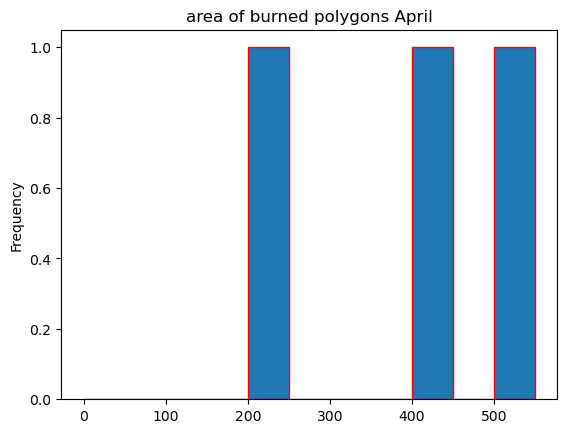

In [93]:
print(len(Canada_full_new_4['ADJ_HA']))
Canada_full_new_4['ADJ_HA'].plot.hist(bins=bins_area4,title='area of burned polygons April',edgecolor="red")#,binwidth=5)
'''
plt.savefig('polygon area distribution month4.png')
plt.close()
'''

<AxesSubplot:title={'center':'area of burned polygons April'}, ylabel='Frequency'>

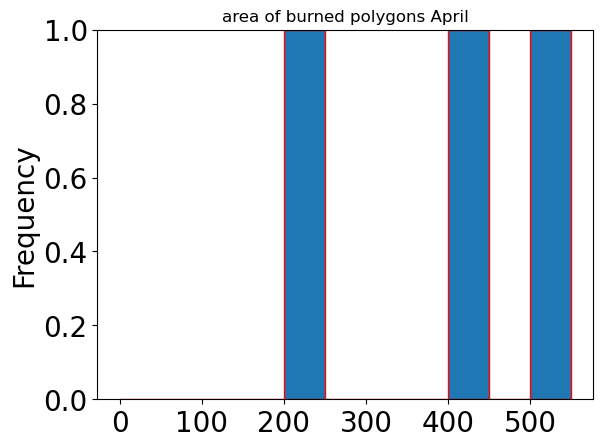

In [94]:
ax = plt.subplot()
plt.gca()
ax.set_ylim([0,1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
Canada_full_new_4['ADJ_HA'].plot.hist(bins=bins_area4,title='area of burned polygons April',edgecolor="red")#,binwidth=5)


In [95]:
step = 1000
bins_area5=list(range(0,ceil(Canada_full_new_5['ADJ_HA'].max())+step,step))
#bins_area5.append(Canada_full_new_5['ADJ_HA'].max())
bins_area5 

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

25


"\nplt.savefig('polygon area distribution month5.png')\nplt.close()\n"

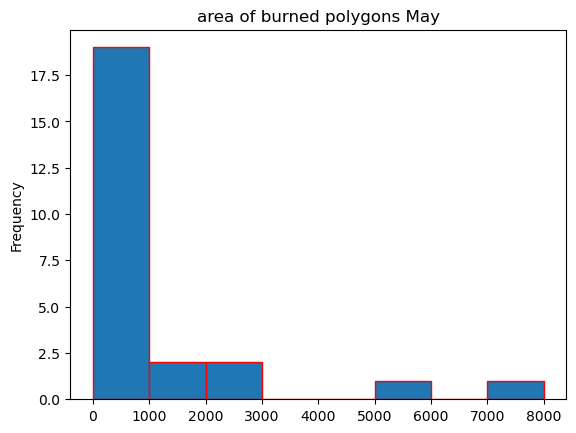

In [96]:
print(len(Canada_full_new_5['ADJ_HA']))
Canada_full_new_5['ADJ_HA'].plot.hist(bins=bins_area5,title='area of burned polygons May',edgecolor='red',xlabel=bins_area5)
'''
plt.savefig('polygon area distribution month5.png')
plt.close()
'''

In [97]:
step = 1000
bins_area6=list(range(0,ceil(Canada_full_new_6['ADJ_HA'].max())+step,step))
#bins_area6.append(Canada_full_new_6['ADJ_HA'].max())

19


"\nplt.savefig('polygon area distribution month6.png')\nplt.close()\n"

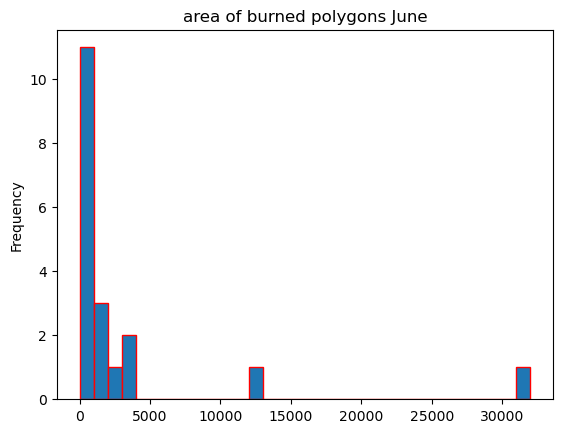

In [98]:
print(len(Canada_full_new_6['ADJ_HA']))
Canada_full_new_6['ADJ_HA'].plot.hist(bins=bins_area6,title='area of burned polygons June',edgecolor='red')
'''
plt.savefig('polygon area distribution month6.png')
plt.close()
'''

In [99]:
step = 5000
bins_area7=list(range(0,ceil(Canada_full_new_7['ADJ_HA'].max())+step,step))
#bins_area7.append(Canada_full_new_7['ADJ_HA'].max())

135


"\nplt.savefig('polygon area distribution month7.png')\nplt.close()\n"

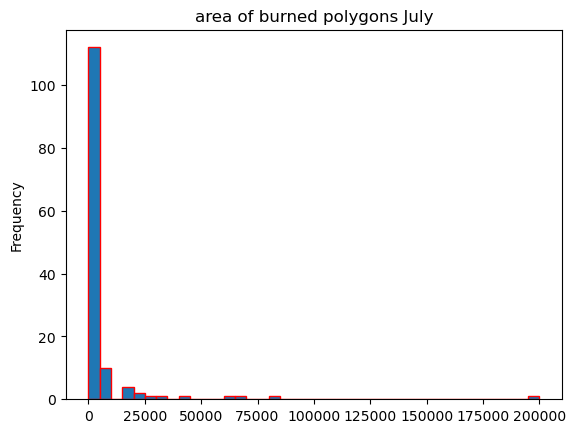

In [100]:
print(len(Canada_full_new_7['ADJ_HA']))
Canada_full_new_7['ADJ_HA'].plot.hist(bins=bins_area7,title='area of burned polygons July',edgecolor='red')
'''
plt.savefig('polygon area distribution month7.png')
plt.close()
'''

In [101]:
step = 1000
bins_area8=list(range(0,ceil(Canada_full_new_8['ADJ_HA'].max())+step,step))
#bins_area8.append(Canada_full_new_8['ADJ_HA'].max())

32


"\nplt.savefig('polygon area distribution month8.png')\nplt.close()\n"

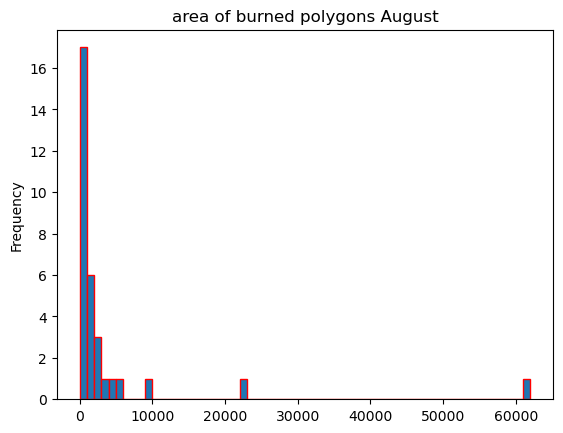

In [102]:
print(len(Canada_full_new_8['ADJ_HA']))
Canada_full_new_8['ADJ_HA'].plot.hist(bins=bins_area8,title='area of burned polygons August',edgecolor='red')
'''
plt.savefig('polygon area distribution month8.png')
plt.close()
'''

In [103]:
step = 10000
bins_area9=list(range(0,ceil(Canada_full_new_9['ADJ_HA'].max())+step,step))
#bins_area9.append(Canada_full_new_9['ADJ_HA'].max())

17


"\nplt.savefig('polygon area distribution month9.png')\nplt.close()\n"

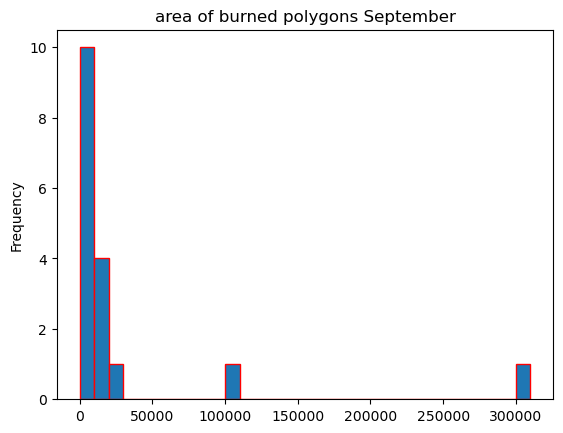

In [104]:
print(len(Canada_full_new_9['ADJ_HA']))
Canada_full_new_9['ADJ_HA'].plot.hist(bins=bins_area9,title='area of burned polygons September',edgecolor='red')
'''
plt.savefig('polygon area distribution month9.png')
plt.close()
'''

## Visualize Polygons

In [105]:
Canada_full_new_6['geometry']

27     MULTIPOLYGON (((-1282026.429 2122270.423, -128...
32     MULTIPOLYGON (((-1593315.081 2629775.008, -159...
37     POLYGON ((-731905.429 2682004.003, -731818.153...
56     MULTIPOLYGON (((-1202249.645 2306389.763, -120...
57     POLYGON ((-1168937.774 2493802.718, -1168944.5...
63     POLYGON ((-1210303.528 2450771.440, -1210315.3...
82     MULTIPOLYGON (((-1286934.640 2126069.047, -128...
96     MULTIPOLYGON (((-1301356.442 2133834.454, -130...
99     MULTIPOLYGON (((-924817.505 1917395.639, -9248...
118    POLYGON ((-899695.045 2836050.312, -899646.980...
121    POLYGON ((-897713.439 2322911.149, -897771.983...
136    MULTIPOLYGON (((-1284365.142 2115199.485, -128...
160    MULTIPOLYGON (((-1018338.417 2362848.811, -101...
161    POLYGON ((-996922.865 2391424.335, -996892.695...
163    POLYGON ((-907124.774 2207914.464, -907081.135...
168    MULTIPOLYGON (((-1748924.623 3391581.718, -174...
192    POLYGON ((-744441.289 2662426.076, -744400.123...
209    POLYGON ((-1387664.498 2

"\nplt.savefig('set6_polygons.png')\nplt.close()\n"

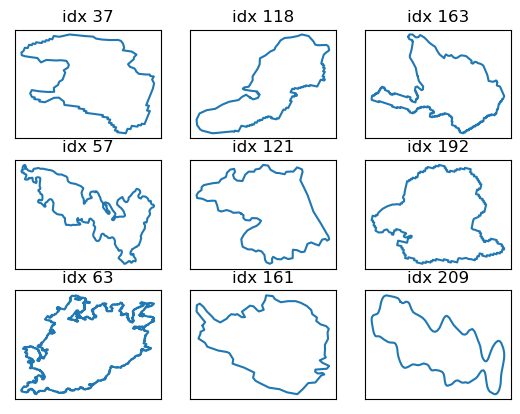

In [106]:
single = [37,57,63,118,121,161,163,192,209]
counter = 0

fig,ax = plt.subplots(nrows=3,ncols=3)

for idx in single:
    shape = Canada_full_new_6['geometry'][idx]
    area1 = shape.area/10000
    x,y = shape.exterior.xy
    i = counter%3 
    j = counter//3
    ax[i,j].plot(x,y)
    ax[i,j].title.set_text('idx {}'.format(idx))
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    counter = counter + 1
'''
plt.savefig('set6_polygons.png')
plt.close()
'''

In [107]:
multi = [27,32,56,82,96,99,136,160,168,216]

counter = 0

fig,ax = plt.subplots(nrows=2,ncols=5)

for idx in multi:
    shape = Canada_full_new_6['geometry'][idx]
    area2 = shape.area/10000
    i = counter//5 
    j = counter%5

    for geom in shape.geoms:
        x,y = geom.exterior.xy
        ax[i,j].plot(x,y)
    ax[i,j].title.set_text('idx {}'.format(idx)) 
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    
    counter = counter + 1    
plt.savefig('set6_multipolygons.png')
plt.close()

In [108]:
display(Canada_full_new_7['geometry'])

0      MULTIPOLYGON (((-242457.942 2190912.919, -2424...
2      POLYGON ((-973106.670 2333155.965, -973097.434...
3      MULTIPOLYGON (((2083423.726 1802154.140, 20834...
4      POLYGON ((2042581.681 1704737.457, 2042581.541...
5      POLYGON ((-413531.659 2139532.960, -413480.357...
                             ...                        
223    POLYGON ((289406.597 1533613.311, 289459.483 1...
225    POLYGON ((255225.208 1538177.760, 255191.194 1...
226    POLYGON ((197702.833 1518129.697, 197706.145 1...
227    POLYGON ((374152.667 1509676.181, 374178.378 1...
228    POLYGON ((1061928.049 1002747.517, 1061916.921...
Name: geometry, Length: 135, dtype: geometry

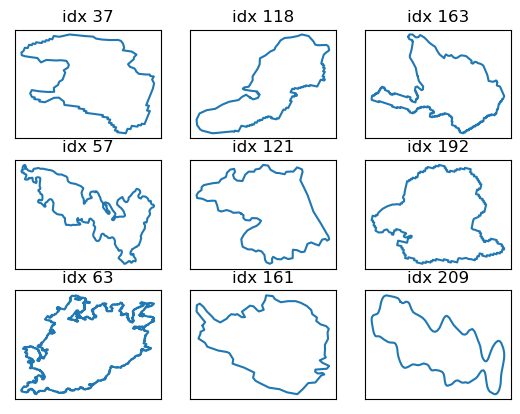

In [109]:
single = [37,57,63,118,121,161,163,192,209]
counter = 0

fig,ax = plt.subplots(nrows=3,ncols=3)

for idx in single:
    shape = Canada_full_new_6['geometry'][idx]
    area1 = shape.area/10000
    x,y = shape.exterior.xy
    i = counter%3 
    j = counter//3
    ax[i,j].plot(x,y)
    ax[i,j].title.set_text('idx {}'.format(idx))
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    counter = counter + 1

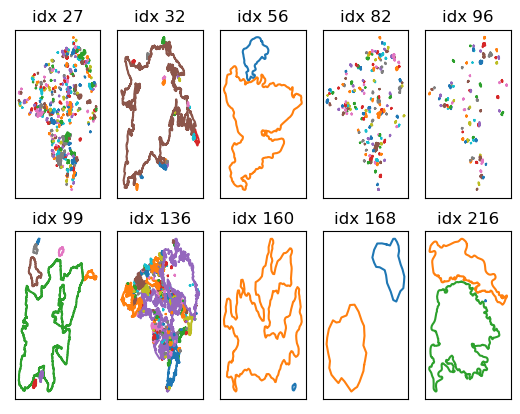

In [110]:
multi = [27,32,56,82,96,99,136,160,168,216]

counter = 0

fig,ax = plt.subplots(nrows=2,ncols=5)

for idx in multi:
    shape = Canada_full_new_6['geometry'][idx]
    area2 = shape.area/10000
    i = counter//5 
    j = counter%5

    for geom in shape.geoms:
        x,y = geom.exterior.xy
        ax[i,j].plot(x,y)
    ax[i,j].title.set_text('idx {}'.format(idx)) 
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    
    counter = counter + 1    

In [111]:
month_poly = [Canada_full_new_4.shape[0],
              Canada_full_new_5.shape[0],
              Canada_full_new_6.shape[0],
              Canada_full_new_7.shape[0],
              Canada_full_new_8.shape[0],
              Canada_full_new_9.shape[0]]
month_poly

[3, 25, 19, 135, 32, 17]

In [112]:
for ia in list(range(10)):
    print(ia%5,ia//5)

0 0
1 0
2 0
3 0
4 0
0 1
1 1
2 1
3 1
4 1


In [113]:
month_burn = [Canada_full_new_4_burn_area,
              Canada_full_new_5_burn_area,
              Canada_full_new_6_burn_area,
              Canada_full_new_7_burn_area,
              Canada_full_new_8_burn_area,
              Canada_full_new_9_burn_area]
month_burn

[1194.103928338,
 27102.872148944498,
 62232.942682400004,
 815862.5255424407,
 129799.660736446,
 544118.31415954]

In [114]:
month = ['April','May','June','July','August','September']

In [115]:
dict_data = {'month':month,'month_poly':month_poly,'month_burn':month_burn}
dict_data_df = pd.DataFrame(dict_data)
dict_data_df

,month,month_poly,month_burn
0,April,3,1194.103928
1,May,25,27102.872149
2,June,19,62232.942682
3,July,135,815862.525542
4,August,32,129799.660736
5,September,17,544118.314160


"\nplt.savefig('burn_polygons_by_month.png')\nplt.close()\n"

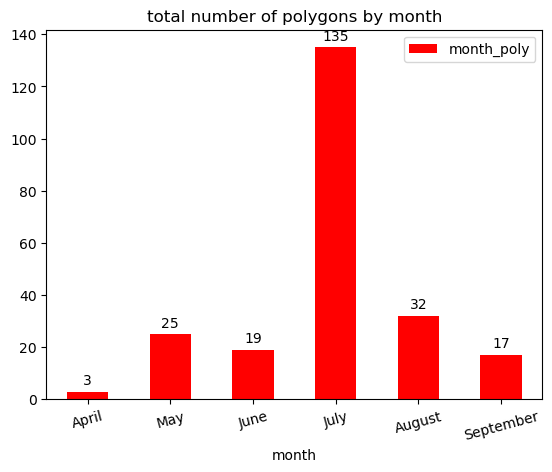

In [124]:
temp = dict_data_df.drop(['month_burn'],axis=1)
#temp
ax = temp.plot.bar(x='month',
              y='month_poly',
              color='red',
              title='total number of polygons by month')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(rotation=15, horizontalalignment="center")
'''
plt.savefig('burn_polygons_by_month.png')
plt.close()
'''

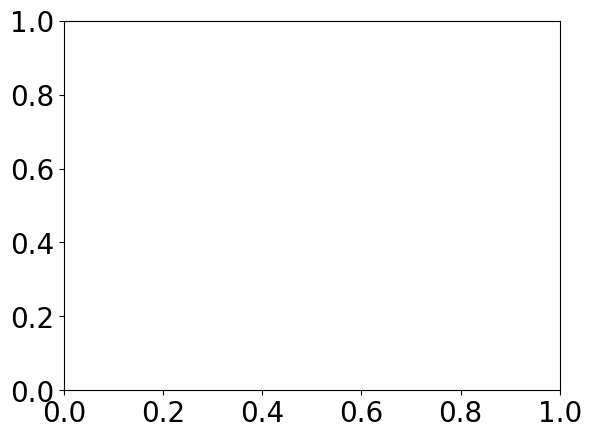

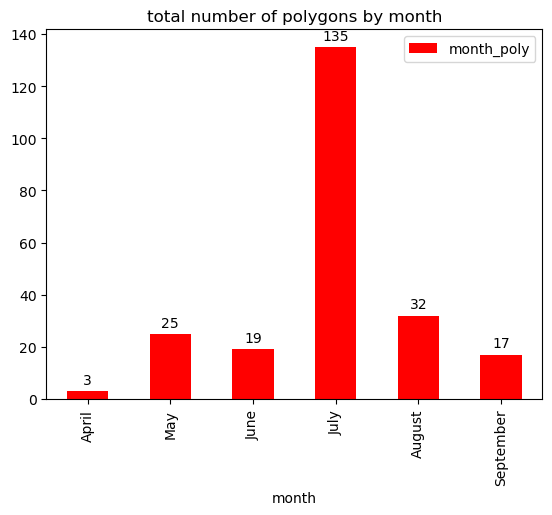

In [117]:
temp = dict_data_df.drop(['month_burn'],axis=1)
ax = plt.subplot()
plt.gca()
#ax.set_ylim([0,1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax = temp.plot.bar(x='month',
              y='month_poly',
              color='red',
              title='total number of polygons by month')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

In [125]:
temp = dict_data_df.drop(['month_poly'],axis=1)

ax = temp.plot.bar(x='month',color='blue',title='burned area by month')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(),'.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(rotation=15, horizontalalignment="center")
plt.savefig('burn_parea_by_month.png')
plt.close()

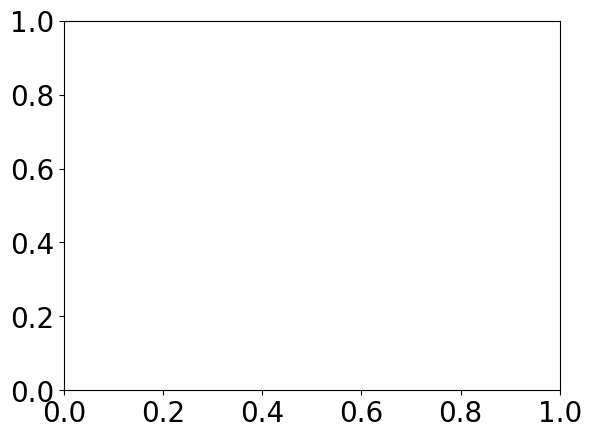

In [119]:
ax = plt.subplot()
plt.gca()
ax.set_ylim([0,1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# Save polygons by month as shape file

## April

In [ ]:
Canada_full_new_4.columns

In [ ]:
Canada_full_new_4_filtered = Canada_full_new_4.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_4_filtered

In [ ]:
#Canada_full_new_4_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_april.shp")

## May

In [ ]:
Canada_full_new_5.columns

In [ ]:
Canada_full_new_5_filtered = Canada_full_new_5.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_5_filtered

In [ ]:
#Canada_full_new_5_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_may.shp")

## June

In [ ]:
Canada_full_new_6.columns

In [ ]:
Canada_full_new_6_filtered = Canada_full_new_6.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_6_filtered

In [ ]:
#Canada_full_new_6_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_june.shp")

## July

In [ ]:
Canada_full_new_7.columns

In [ ]:
Canada_full_new_7_filtered = Canada_full_new_7.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_7_filtered

In [ ]:
#Canada_full_new_7_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_july.shp")

## August

In [ ]:
Canada_full_new_8.columns

In [ ]:
Canada_full_new_8_filtered = Canada_full_new_8.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_8_filtered

In [ ]:
#Canada_full_new_8_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_august.shp")

## September

In [ ]:
Canada_full_new_9.columns

In [ ]:
Canada_full_new_9_filtered = Canada_full_new_9.drop(['YEAR', 'NFIREID', 'BASRC',
                                                     'FIREMAPS','FIREMAPM', 'FIRECAUS',
                                                     'BURNCLAS', 'SDATE', 'EDATE',
                                                     'AFSDATE', 'AFEDATE','CAPDATE',
                                                     'ADJ_FLAG','AGENCY',
                                                     'BT_GID', 'VERSION','COMMENTS',
                                                     'Sdate_new', 'Edate_new'],
                                                    axis=1)
Canada_full_new_9_filtered

In [ ]:
#Canada_full_new_9_filtered.to_file("month_db_esri_102002/Canada_burnedArea_polygons_september.shp")

# Combining sets based on proximity

 * Set1: 4 & 5 
 * Set2: 4 & 5 & 6
 * Set3: 4 & 5 & 6 & 7  
 * Set4: 4 & 5 & 6 & 7 & 8 
 * Set5: 4 & 5 & 6 & 7 & 8 & 9
  

# Functions

In [ ]:
def check_polygon_intersection(distance,polygon_set):
        set_poly = polygon_set['geometry']
        set_BB_coor_buffered = []
        
        BB_type = []
        BB_coor = []
        for poly in set_poly:
            BB_type.append(poly.type) 
            boundaries = Polygon(poly.envelope)
            BB_coor.append(boundaries)  
    
            boundaries_buffered = boundaries.buffer(distance)
            set_BB_coor_buffered.append(boundaries_buffered)
        
        pairs_idx_list = itertools.combinations(list(range(len(set_BB_coor_buffered))),2)
        status_map = np.zeros([len(set_BB_coor_buffered),
                               len(set_BB_coor_buffered)])
        
        for pair in pairs_idx_list:
            poly_1 = set_BB_coor_buffered[pair[0]]
            poly_2 = set_BB_coor_buffered[pair[1]]
            if poly_1.intersects(poly_2):
                status_map[pair[0],pair[1]] = 1
                status_map[pair[1],pair[0]] = 1 

        return status_map,set_BB_coor_buffered


In [ ]:
def group_polygons(contact_map,polygon_set):
    set_poly = polygon_set['geometry']
    
    ref_list = [] # rows that has aleady been processed
    polygons_grouped =[] # list of lists of intersecting polygons

    for row_idx in list(range(contact_map.shape[0])):
        ref_list_temp = [] # list that contains elements already processed for this iteration

        if row_idx in ref_list: # Element already process, skip it 
            
            continue
        else:
            ref_list.append(row_idx) # Add element to ref list to avoid reporecessing it
            sample = list(np.nonzero(contact_map[row_idx,:])[0]) # Get all the elements related to row_idx
            
            if len(sample) == 0: # if there are no elements related to row_idx, skip it 
                ref_list_temp.append(row_idx)
                polygons_grouped.append(ref_list_temp)
                
                continue

            else: # if there are elements related to row_idx, then start processing 
                ref_list_temp.append(row_idx) # add current row_idx to temporary list to make sure it is only processed once

                while len(sample) > 0: 
                    elem = sample[0] # get first element from list of related elements 
                    sample.remove(elem) # remove first element from list of related elements
                    ref_list.append(elem)

                    sample_temp = list(np.nonzero(contact_map[elem,:])[0]) # get elements related to first element in sample list

                    ref_list_temp.append(elem) # add 

                    sample_set = set(sample)
                    sample_temp_set = set(sample_temp)
                    sample_union = sample_set | sample_temp_set

                    sample = list(sample_union)

                    for elem_ref in ref_list_temp:
                        if elem_ref in sample:
                            sample.remove(elem_ref)

                polygons_grouped.append(ref_list_temp)

    return polygons_grouped

A valid Polygon may not possess any overlapping exterior or interior rings. A valid MultiPolygon may not collect any overlapping polygons. Operations on invalid features may fail.

In [ ]:
def combine_polygons(intersections_list,polygon_set,crs_ref):
    
    set_poly = polygon_set['geometry']
    download_start = polygon_set['Download_date_start']
    download_end   = polygon_set['Download_date_end']
    
    poly_list    = []
    poly_BB_list = []
    poly_start_date = []
    poly_end_date   = []

    for case in intersections_list:
        print('processing {}'.format(case))
        # Single polygon list
        if len(case) == 1:
            print('processing single polygon list')
            
            poly = set_poly[case[0]]
            poly_list.append(poly)
            poly_start_date.append(download_start[case[0]])
            poly_end_date.append(download_end[case[0]])
            
            poly_env = poly.envelope
            xmin,ymin,xmax,ymax = poly_env.bounds
            dimx = xmax-xmin
            dimy = ymax-ymin

            if dimx > 100000 or dimy > 100000:
                poly_BB_list.append(poly_env)
                
            else:
                poly_BB = poly.buffer(50000,cap_style=3)
                poly_BB_list.append(poly_BB)
        
        # Multiple polygon list
        else:
            print('processing multiple polygon list')
            
            temp_list  = []
            temp_start = []
            temp_end   = []
            
            for elem_idx in case:
                poly_list.append(set_poly[elem_idx])
                temp_list.append(set_poly[elem_idx])
                temp_start.append(download_start[elem_idx])
                temp_end.append(download_end[elem_idx])
            
            print('min start date {}'.format(min(temp_start)))
            print('max start date {}'.format(max(temp_start)))
            print('min end   date {}'.format(min(temp_end)))
            print('max end   date {}'.format(max(temp_end)))
            
            poly_start_date.append(max(temp_start))
            poly_end_date.append(max(temp_end))
            
            print('    create geodataframe')
            dict_temp = {'geometry':temp_list}
            temp_gpd  = gpd.GeoDataFrame(dict_temp,crs=crs_ref,geometry='geometry')
            temp_gpd_convex = temp_gpd.convex_hull
            
            print('    perform union')
            union     = temp_gpd_convex.unary_union
            print('    create envelope')
            union_env  = union.envelope

            xmin,ymin,xmax,ymax = union_env.bounds
            dimx = xmax-xmin
            dimy = ymax-ymin
            print('    check dimensions')
            if dimx > 100000 or dimy > 100000:
                poly_BB_list.append(union_env)
                
            else:
                union_BB = union_env.buffer(50000,cap_style=3)
                poly_BB_list.append(union_BB)
                
        
    return poly_list,poly_BB_list,poly_start_date,poly_end_date

In [ ]:
dist = 25000
upper_area_threshold = 500 # Ha

## Set1: 

In [ ]:
set1 = Canada_full_new_4_filtered.append(Canada_full_new_5_filtered)

In [ ]:
set1_sorted = set1.sort_values(by=['ADJ_HA'],ascending=False,ignore_index=True)
set1_sorted

In [ ]:
#poly_0 = set1_sorted_temp.loc[[0],['geometry']]
poly_0 = set1_sorted['geometry']
BB = poly_0.envelope
BB = BB.buffer(dist,cap_style=3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set1_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set1_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)
plt.savefig('set1_polyandBB_all.png')
plt.close()

In [ ]:
set1_arr_status,set1_BB_coor_buffered = check_polygon_intersection(dist,set1_sorted)

In [ ]:
#ax.imshow()
plt.imshow(set1_arr_status)
ax = plt.gca()
ax.set_xticks(np.arange(0, set1_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set1_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set1_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set1_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)

In [ ]:
#ax.imshow()
plt.imshow(set1_arr_status)
ax = plt.gca()
ax.set_xticks(np.arange(0, set1_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set1_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set1_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set1_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)
plt.savefig('set1_contact_map.png')
plt.close()

## group intersecting polygons together

In [ ]:
if np.sum(set1_arr_status) > 0:
    intersecting_poly_list = group_polygons(set1_arr_status,set1_sorted)

    total = 0
    one_polygon_set_area   = []
    one_polygon_set_idx = []
    one_polygon_set = 0
    
    multi_polygon_set_area = []
    multi_polygon_set_idx  = []
    idx = 0
    for idx in list(range(len(intersecting_poly_list))):
        li = intersecting_poly_list[idx]
        #print(li)
        total = total + len(li)
        if len(li) == 1:
            one_polygon_set = one_polygon_set+1
            one_polygon_set_area.append(set1_sorted['geometry'][li[0]].area/10000)
            one_polygon_set_idx.append(idx)
            
        else:
            mutli_area = 0
            multi_polygon_set_idx.append(idx)
            for poly_idx in li:
                mutli_area = mutli_area + set1_sorted['geometry'][li[0]].area/10000
            multi_polygon_set_area.append([len(li),mutli_area])
    multi_polygon_set = len(intersecting_poly_list)-one_polygon_set
    
    print("initial total polygons:   {:3d}".format(total))
    print("sets with one polygon:    {:3d}".format(one_polygon_set))
    print("sets with Multi polygons: {:3d}".format(multi_polygon_set))
    print("final total polygons:     {:3d}".format(one_polygon_set+multi_polygon_set))
    print("\n")
    print("single polygons lists   idx {}".format(one_polygon_set_idx))
    print("multiple polygons lists idx {}".format(multi_polygon_set_idx))
else:
    print('No two polygons intesect with each other')

## Filter single/multiple polygon lists with respect to minimum area threshold

In [ ]:
intersecting_poly_list_filtered = []

# single polygon list

print('single polygon lists')
keep_sum_single = 0
drop_sum_single = 0
for poly_idx,poly_area in zip(one_polygon_set_idx,one_polygon_set_area):
    if poly_area >= upper_area_threshold: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha > {}  KEEP'.format(poly_idx,poly_area,upper_area_threshold))
        keep_sum_single = keep_sum_single + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idx])
    else: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha < {}  DROP'.format(poly_idx,poly_area,upper_area_threshold))
        drop_sum_single = drop_sum_single + 1
print('\n')

# Multiple polygon list
print('Multiple polygon list')
keep_sum_multiple = 0
drop_sum_multiple = 0

for poly_idy,pair in zip(multi_polygon_set_idx,multi_polygon_set_area):
    if pair[1] >= upper_area_threshold: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha > {}  KEEP'.format(pair[0],pair[1],upper_area_threshold))
        keep_sum_multiple = keep_sum_multiple + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idy])
    else: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha < {}  DROP'.format(pair[0],pair[1],upper_area_threshold))
        drop_sum_multiple = drop_sum_multiple + 1
print('\n')

print('total number of single polygon sets        : {:2d}'.format(keep_sum_single+drop_sum_single))
print('total number of single polygon sets to KEEP: {:2d}'.format(keep_sum_single))
print('total number of single polygon sets to DROP: {:2d}'.format(drop_sum_single))

print('\n')
print('total number of Multiple polygon sets        : {:2d}'.format(keep_sum_multiple+drop_sum_multiple))
print('total number of Multiple polygon sets to KEEP: {:2d}'.format(keep_sum_multiple))
print('total number of Multiple polygon sets to DROP: {:2d}'.format(drop_sum_multiple))

print('\n')
print('indexes of polygon to keep')
print('{}'.format(intersecting_poly_list_filtered))

In [ ]:
set1_sorted

### Combine intersecting Bounding boxes

In [ ]:
if np.sum(set1_arr_status) > 0:
    
    poly_combine_list,poly_combine_BB_list,poly_combine_start_date,poly_combine_end_date = combine_polygons(intersecting_poly_list_filtered,set1_sorted,set1_sorted.crs)
    
    poly_combine_dict = {'poly_combine':poly_combine_list}
    poly_combine_gpd1 = gpd.GeoDataFrame(poly_combine_dict,
                                            crs=set1_sorted.crs,
                                            geometry='poly_combine')
    
    poly_combine_BB_dict = {'BB_combine':poly_combine_BB_list,
                            'download_start_date':poly_combine_start_date,
                            'download_end_date':poly_combine_end_date}
    poly_combine_BB_gpd1 = gpd.GeoDataFrame(poly_combine_BB_dict,
                                                     crs=set1_sorted.crs,
                                                     geometry='BB_combine')
else:
    print('No two polygons intesect with each other')

In [ ]:
poly_combine_gpd1['poly_combine'][15]

In [ ]:
poly_combine_BB_gpd1

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd1.plot(ax=base, color='black')
poly_combine_BB_gpd1.plot(ax=base, color='red',alpha=0.5)
#plt.savefig('BCmap_firearea.png')
#plt.close()

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd1.plot(ax=base, color='black')
poly_combine_BB_gpd1.plot(ax=base, color='red',alpha=0.5)
plt.savefig('set1_polyandBB_filtered.png')
plt.close()

## Plot each BB by itself

In [ ]:
counter1 = 0
for poly in poly_combine_BB_gpd1['BB_combine']:
    single_poly = [poly]
    dict_temp = {'single_poly':single_poly}
    geo_temp  = gpd.GeoDataFrame(dict_temp,crs=poly_combine_BB_gpd1.crs,geometry='single_poly')
    
    base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
    poly_combine_gpd1.plot(ax=base, color='black')
    geo_temp.plot(ax=base, color='red',alpha=0.5)
    plt.savefig('BB_sinlge_plot/set1/set1_polyandpng_filtered_{}.png'.format(counter1))
    plt.close()
    counter1 = counter1 + 1

## Area of each BB and its xdim and ydim

In [ ]:
set1_BB_area = poly_combine_BB_gpd1['BB_combine'].area

dimx_list1  = []
dimy_list1  = []
total_list1 = []

for poly_sample in poly_combine_BB_gpd1['BB_combine']:
    xmin,ymin,xmax,ymax = poly_sample.bounds
    dimx = xmax-xmin
    dimy = ymax-ymin
    dimx_list1.append(dimx)
    dimy_list1.append(dimy)
    
    
    x_number = ceil(dimx/100000)
    y_number = ceil(dimy/100000)
    total    = x_number*y_number
    
    total_list1.append(total)

In [ ]:
dict_dim_1 = {'area':set1_BB_area,'dimx':dimx_list1,'dimy':dimy_list1,'total_images':total_list1}
df_dim1    = pd.DataFrame(dict_dim_1)
df_dim1

In [ ]:
poly_combine_gpd1.to_file("polygons_database/CanadaFull_firearea_polygons_set_1.shp")

# Set2:

In [ ]:
set2_temp = Canada_full_new_4_filtered.append(Canada_full_new_5_filtered)
set2 = set2_temp.append(Canada_full_new_6_filtered)

In [ ]:
set2_sorted = set2.sort_values(by=['ADJ_HA'],ascending=False,ignore_index=True)
set2_sorted

In [ ]:
#poly_0 = set1_sorted_temp.loc[[0],['geometry']]
poly_0 = set2_sorted['geometry']
BB = poly_0.envelope
BB = BB.buffer(dist,cap_style=3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set2_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set2_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)
plt.savefig('set2_polyandBB_all.png')
plt.close()

In [ ]:
set2_arr_status,set2_BB_coor_buffered = check_polygon_intersection(dist,set2_sorted)

In [ ]:
#ax.imshow()
plt.imshow(set2_arr_status)
ax = plt.gca()
ax.set_xticks(np.arange(0, set2_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set2_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set2_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set2_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=1)

In [ ]:
#ax.imshow()
plt.imshow(set2_arr_status)
ax = plt.gca()
ax.set_xticks(np.arange(0, set2_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set2_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set2_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set2_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=1)
plt.savefig('set2_contact_map.png')
plt.close()

## group intersecting polygons together

In [ ]:
if np.sum(set2_arr_status) > 0:
    intersecting_poly_list = group_polygons(set2_arr_status,set2_sorted)

    total = 0
    one_polygon_set_area   = []
    one_polygon_set_idx = []
    one_polygon_set = 0
    
    multi_polygon_set_area = []
    multi_polygon_set_idx  = []
    idx = 0
    for idx in list(range(len(intersecting_poly_list))):
        li = intersecting_poly_list[idx]
        #print(li)
        total = total + len(li)
        if len(li) == 1:
            one_polygon_set = one_polygon_set+1
            one_polygon_set_area.append(set2_sorted['geometry'][li[0]].area/10000)
            one_polygon_set_idx.append(idx)
            
        else:
            mutli_area = 0
            multi_polygon_set_idx.append(idx)
            for poly_idx in li:
                mutli_area = mutli_area + set2_sorted['geometry'][li[0]].area/10000
            multi_polygon_set_area.append([len(li),mutli_area])
    multi_polygon_set = len(intersecting_poly_list)-one_polygon_set
    
    print("initial total polygons:   {:3d}".format(total))
    print("sets with one polygon:    {:3d}".format(one_polygon_set))
    print("sets with Multi polygons: {:3d}".format(multi_polygon_set))
    print("final total polygons:     {:3d}".format(one_polygon_set+multi_polygon_set))
    print("\n")
    print("single polygons lists   idx {}".format(one_polygon_set_idx))
    print("multiple polygons lists idx {}".format(multi_polygon_set_idx))
else:
    print('No two polygons intesect with each other')

## Filter single/multiple polygon lists with respect to minimum area threshold

In [ ]:
intersecting_poly_list_filtered = []

# single polygon list

print('single polygon lists')
keep_sum_single = 0
drop_sum_single = 0
for poly_idx,poly_area in zip(one_polygon_set_idx,one_polygon_set_area):
    if poly_area >= upper_area_threshold: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha > {}  KEEP'.format(poly_idx,poly_area,upper_area_threshold))
        keep_sum_single = keep_sum_single + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idx])
    else: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha < {}  DROP'.format(poly_idx,poly_area,upper_area_threshold))
        drop_sum_single = drop_sum_single + 1
print('\n')

# Multiple polygon list
print('Multiple polygon list')
keep_sum_multiple = 0
drop_sum_multiple = 0

for poly_idy,pair in zip(multi_polygon_set_idx,multi_polygon_set_area):
    if pair[1] >= upper_area_threshold: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha > {}  KEEP'.format(pair[0],pair[1],upper_area_threshold))
        keep_sum_multiple = keep_sum_multiple + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idy])
    else: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha < {}  DROP'.format(pair[0],pair[1],upper_area_threshold))
        drop_sum_multiple = drop_sum_multiple + 1
print('\n')

print('total number of single polygon sets        : {:2d}'.format(keep_sum_single+drop_sum_single))
print('total number of single polygon sets to KEEP: {:2d}'.format(keep_sum_single))
print('total number of single polygon sets to DROP: {:2d}'.format(drop_sum_single))

print('\n')
print('total number of Multiple polygon sets        : {:2d}'.format(keep_sum_multiple+drop_sum_multiple))
print('total number of Multiple polygon sets to KEEP: {:2d}'.format(keep_sum_multiple))
print('total number of Multiple polygon sets to DROP: {:2d}'.format(drop_sum_multiple))

print('\n')
print('indexes of polygon to keep')
print('{}'.format(intersecting_poly_list_filtered))

### Combine intersecting Bounding boxes

In [ ]:
if np.sum(set2_arr_status) > 0:
    
    poly_combine_list,poly_combine_BB_list,poly_combine_start_date,poly_combine_end_date = combine_polygons(intersecting_poly_list_filtered,set2_sorted,set2_sorted.crs)
    
    poly_combine_dict = {'poly_combine':poly_combine_list}
    poly_combine_gpd2 = gpd.GeoDataFrame(poly_combine_dict,
                                            crs=set2_sorted.crs,
                                            geometry='poly_combine')
    
    poly_combine_BB_dict = {'BB_combine':poly_combine_BB_list,
                            'download_start_date':poly_combine_start_date,
                            'download_end_date':poly_combine_end_date}
    poly_combine_BB_gpd2 = gpd.GeoDataFrame(poly_combine_BB_dict,
                                                     crs=set2_sorted.crs,
                                                     geometry='BB_combine')
else:
    print('No two polygons intesect with each other')

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd2.plot(ax=base, color='black')
poly_combine_BB_gpd2.plot(ax=base, color='red',alpha=0.5)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd2.plot(ax=base, color='black')
poly_combine_BB_gpd2.plot(ax=base, color='red',alpha=0.5)
plt.savefig('set2_polyandBB_filtered.png')
plt.close()

## Plot each BB by itself

In [ ]:
counter2 = 0
for poly in poly_combine_BB_gpd2['BB_combine']:
    single_poly = [poly]
    dict_temp = {'single_poly':single_poly}
    geo_temp  = gpd.GeoDataFrame(dict_temp,crs=poly_combine_BB_gpd2.crs,geometry='single_poly')
    
    base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
    poly_combine_gpd2.plot(ax=base, color='black')
    geo_temp.plot(ax=base, color='red',alpha=0.5)
    plt.savefig('BB_sinlge_plot/set2/set2_polyandpng_filtered_{}.png'.format(counter2))
    plt.close()
    counter2 = counter2 + 1

## Area of each BB and its xdim and ydim

In [ ]:
set2_BB_area = poly_combine_BB_gpd2['BB_combine'].area

dimx_list2  = []
dimy_list2  = []
total_list2 = []

for poly_sample in poly_combine_BB_gpd2['BB_combine']:
    xmin,ymin,xmax,ymax = poly_sample.bounds
    dimx = xmax-xmin
    dimy = ymax-ymin
    dimx_list2.append(dimx)
    dimy_list2.append(dimy)
    
    
    x_number = ceil(dimx/100000)
    y_number = ceil(dimy/100000)
    total    = x_number*y_number
    
    total_list2.append(total)

In [ ]:
dict_dim_2 = {'area':set2_BB_area,'dimx':dimx_list2,'dimy':dimy_list2,'total_images':total_list2}
df_dim2    = pd.DataFrame(dict_dim_2)
df_dim2

In [ ]:
poly_combine_gpd2.to_file("polygons_database/CanadaFull_firearea_polygons_set_2.shp")

# Set3:

In [ ]:
set3_temp1 = Canada_full_new_4_filtered.append(Canada_full_new_5_filtered)
set3_temp2 = set3_temp1.append(Canada_full_new_6_filtered)
set3       = set3_temp2.append(Canada_full_new_7_filtered)

In [ ]:
set3_sorted = set3.sort_values(by=['ADJ_HA'],ascending=False,ignore_index=True)
set3_sorted

In [ ]:
#poly_0 = set1_sorted_temp.loc[[0],['geometry']]
poly_0 = set3_sorted['geometry']
BB = poly_0.envelope
BB = BB.buffer(dist,cap_style=3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set3_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set3_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)
plt.savefig('set3_polyandBB_all.png')
plt.close()

In [ ]:
set3_arr_status,set3_BB_coor_buffered = check_polygon_intersection(dist,set3_sorted)

In [ ]:
plt.imshow(set3_arr_status)
'''
ax = plt.gca()
ax.set_xticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)
'''

In [ ]:
plt.imshow(set3_arr_status)
'''
ax = plt.gca()
ax.set_xticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)
'''
plt.savefig('set3_contact_map.png')
plt.close()

## group intersecting polygons together

In [ ]:
if np.sum(set3_arr_status) > 0:
    intersecting_poly_list = group_polygons(set3_arr_status,set3_sorted)

    total = 0
    one_polygon_set_area   = []
    one_polygon_set_idx = []
    one_polygon_set = 0
    
    multi_polygon_set_area = []
    multi_polygon_set_idx  = []
    idx = 0
    for idx in list(range(len(intersecting_poly_list))):
        li = intersecting_poly_list[idx]
        #print(li)
        total = total + len(li)
        if len(li) == 1:
            one_polygon_set = one_polygon_set+1
            one_polygon_set_area.append(set3_sorted['geometry'][li[0]].area/10000)
            one_polygon_set_idx.append(idx)
            
        else:
            mutli_area = 0
            multi_polygon_set_idx.append(idx)
            for poly_idx in li:
                mutli_area = mutli_area + set3_sorted['geometry'][li[0]].area/10000
            multi_polygon_set_area.append([len(li),mutli_area])
    multi_polygon_set = len(intersecting_poly_list)-one_polygon_set
    
    print("initial total polygons:   {:3d}".format(total))
    print("sets with one polygon:    {:3d}".format(one_polygon_set))
    print("sets with Multi polygons: {:3d}".format(multi_polygon_set))
    print("final total polygons:     {:3d}".format(one_polygon_set+multi_polygon_set))
    print("\n")
    print("single polygons lists   idx {}".format(one_polygon_set_idx))
    print("multiple polygons lists idx {}".format(multi_polygon_set_idx))
else:
    print('No two polygons intesect with each other')

## Filter single/multiple polygon lists with respect to minimum area threshold

In [ ]:
intersecting_poly_list_filtered = []

# single polygon list

print('single polygon lists')
keep_sum_single = 0
drop_sum_single = 0
for poly_idx,poly_area in zip(one_polygon_set_idx,one_polygon_set_area):
    if poly_area >= upper_area_threshold: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha > {}  KEEP'.format(poly_idx,poly_area,upper_area_threshold))
        keep_sum_single = keep_sum_single + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idx])
    else: 
        print('polygon index in orginial set : {:2d} area {:7.2f} Ha < {}  DROP'.format(poly_idx,poly_area,upper_area_threshold))
        drop_sum_single = drop_sum_single + 1
print('\n')

# Multiple polygon list
print('Multiple polygon list')
keep_sum_multiple = 0
drop_sum_multiple = 0

for poly_idy,pair in zip(multi_polygon_set_idx,multi_polygon_set_area):
    if pair[1] >= upper_area_threshold: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha > {}  KEEP'.format(pair[0],pair[1],upper_area_threshold))
        keep_sum_multiple = keep_sum_multiple + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idy])
    else: 
        print('number of polygons in this set: {:2d} area {:7.2f} Ha < {}  DROP'.format(pair[0],pair[1],upper_area_threshold))
        drop_sum_multiple = drop_sum_multiple + 1
print('\n')

print('total number of single polygon sets        : {:2d}'.format(keep_sum_single+drop_sum_single))
print('total number of single polygon sets to KEEP: {:2d}'.format(keep_sum_single))
print('total number of single polygon sets to DROP: {:2d}'.format(drop_sum_single))

print('\n')
print('total number of Multiple polygon sets        : {:2d}'.format(keep_sum_multiple+drop_sum_multiple))
print('total number of Multiple polygon sets to KEEP: {:2d}'.format(keep_sum_multiple))
print('total number of Multiple polygon sets to DROP: {:2d}'.format(drop_sum_multiple))

print('\n')
print('indexes of polygon to keep')
print('{}'.format(intersecting_poly_list_filtered))

### Combine intersecting Bounding boxes

In [ ]:
if np.sum(set3_arr_status) > 0:
    
    poly_combine_list,poly_combine_BB_list,poly_combine_start_date,poly_combine_end_date = combine_polygons(intersecting_poly_list_filtered,set3_sorted,set3_sorted.crs)
    
    poly_combine_dict = {'poly_combine':poly_combine_list}
    poly_combine_gpd3 = gpd.GeoDataFrame(poly_combine_dict,
                                            crs=set3_sorted.crs,
                                            geometry='poly_combine')
    
    poly_combine_BB_dict = {'BB_combine':poly_combine_BB_list,
                            'download_start_date':poly_combine_start_date,
                            'download_end_date':poly_combine_end_date}
    poly_combine_BB_gpd3 = gpd.GeoDataFrame(poly_combine_BB_dict,
                                                     crs=set3_sorted.crs,
                                                     geometry='BB_combine')
else:
    print('No two polygons intesect with each other')

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd3.plot(ax=base, color='black')
poly_combine_BB_gpd3.plot(ax=base, color='red',alpha=0.5)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd3.plot(ax=base, color='black')
poly_combine_BB_gpd3.plot(ax=base, color='red',alpha=0.5)
plt.savefig('set3_polyandBB_filtered.png')
plt.close()

## Plot each BB by itself

In [ ]:
counter3 = 0
for poly in poly_combine_BB_gpd3['BB_combine']:
    single_poly = [poly]
    dict_temp = {'single_poly':single_poly}
    geo_temp  = gpd.GeoDataFrame(dict_temp,crs=poly_combine_BB_gpd3.crs,geometry='single_poly')
    
    base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
    poly_combine_gpd3.plot(ax=base, color='black')
    geo_temp.plot(ax=base, color='red',alpha=0.5)
    plt.savefig('BB_sinlge_plot/set3/set3_polyandpng_filtered_{}.png'.format(counter3))
    plt.close()
    counter3 = counter3 + 1

## Area of each BB and its xdim and ydim

In [ ]:
set3_BB_area = poly_combine_BB_gpd3['BB_combine'].area

dimx_list3  = []
dimy_list3  = []
total_list3 = []

for poly_sample in poly_combine_BB_gpd3['BB_combine']:
    xmin,ymin,xmax,ymax = poly_sample.bounds
    dimx = xmax-xmin
    dimy = ymax-ymin
    dimx_list3.append(dimx)
    dimy_list3.append(dimy)
    
    
    x_number = ceil(dimx/100000)
    y_number = ceil(dimy/100000)
    total    = x_number*y_number
    
    total_list3.append(total)

In [ ]:
dict_dim_3 = {'area':set3_BB_area,'dimx':dimx_list3,'dimy':dimy_list3,'total_images':total_list3}
df_dim3    = pd.DataFrame(dict_dim_3)
df_dim3

In [ ]:
poly_combine_gpd3.to_file("polygons_database/CanadaFull_firearea_polygons_set_3.shp")

# Set4:

In [ ]:
set4_temp1 = Canada_full_new_4_filtered.append(Canada_full_new_5_filtered)
set4_temp2 = set4_temp1.append(Canada_full_new_6_filtered)
set4_temp3 = set4_temp2.append(Canada_full_new_7_filtered)
set4       = set4_temp3.append(Canada_full_new_8_filtered)

In [ ]:
set4_sorted = set4.sort_values(by=['ADJ_HA'],ascending=False,ignore_index=True)
set4_sorted

In [ ]:
#poly_0 = set1_sorted_temp.loc[[0],['geometry']]
poly_0 = set4_sorted['geometry']
BB = poly_0.envelope
BB = BB.buffer(dist,cap_style=3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set4_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set4_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)
plt.savefig('set4_polyandBB_all.png')
plt.close()

In [ ]:
set4_arr_status,set4_BB_coor_buffered = check_polygon_intersection(dist,set4_sorted)

In [ ]:
plt.imshow(set4_arr_status)
'''
ax = plt.gca()
ax.set_xticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)
'''

In [ ]:
plt.imshow(set4_arr_status)
'''
ax = plt.gca()
ax.set_xticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_yticks(np.arange(0, set3_arr_status.shape[0], 1))
ax.set_xticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.set_yticklabels(np.arange(1, set3_arr_status.shape[1]+1, 1))
ax.grid(color='w', linestyle='-', linewidth=0.5)
'''
plt.savefig('set4_contact_map.png')

## group intersecting polygons together

In [ ]:
if np.sum(set4_arr_status) > 0:
    intersecting_poly_list = group_polygons(set4_arr_status,set4_sorted)

    total = 0
    one_polygon_set_area   = []
    one_polygon_set_idx = []
    one_polygon_set = 0
    
    multi_polygon_set_area = []
    multi_polygon_set_idx  = []
    idx = 0
    for idx in list(range(len(intersecting_poly_list))):
        li = intersecting_poly_list[idx]
        #print(li)
        total = total + len(li)
        if len(li) == 1:
            one_polygon_set = one_polygon_set+1
            one_polygon_set_area.append(set4_sorted['geometry'][li[0]].area/10000)
            one_polygon_set_idx.append(idx)
            
        else:
            mutli_area = 0
            multi_polygon_set_idx.append(idx)
            for poly_idx in li:
                mutli_area = mutli_area + set4_sorted['geometry'][li[0]].area/10000
            multi_polygon_set_area.append([len(li),mutli_area])
    multi_polygon_set = len(intersecting_poly_list)-one_polygon_set
    
    print("initial total polygons:   {:3d}".format(total))
    print("sets with one polygon:    {:3d}".format(one_polygon_set))
    print("sets with Multi polygons: {:3d}".format(multi_polygon_set))
    print("final total polygons:     {:3d}".format(one_polygon_set+multi_polygon_set))
    print("\n")
    print("single polygons lists   idx {}".format(one_polygon_set_idx))
    print("multiple polygons lists idx {}".format(multi_polygon_set_idx))
else:
    print('No two polygons intesect with each other')

In [ ]:
intersecting_poly_list_filtered = []

# single polygon list

print('single polygon lists')
keep_sum_single = 0
drop_sum_single = 0
for poly_idx,poly_area in zip(one_polygon_set_idx,one_polygon_set_area):
    if poly_area >= upper_area_threshold: 
        #print('polygon index in orginial set : {:2d} area {:7.2f} Ha > {}  KEEP'.format(poly_idx,poly_area,upper_area_threshold))
        keep_sum_single = keep_sum_single + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idx])
    else: 
        #print('polygon index in orginial set : {:2d} area {:7.2f} Ha < {}  DROP'.format(poly_idx,poly_area,upper_area_threshold))
        drop_sum_single = drop_sum_single + 1
print('\n')

# Multiple polygon list
print('Multiple polygon list')
keep_sum_multiple = 0
drop_sum_multiple = 0

for poly_idy,pair in zip(multi_polygon_set_idx,multi_polygon_set_area):
    if pair[1] >= upper_area_threshold: 
        #print('number of polygons in this set: {:2d} area {:7.2f} Ha > {}  KEEP'.format(pair[0],pair[1],upper_area_threshold))
        keep_sum_multiple = keep_sum_multiple + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idy])
    else: 
        #print('number of polygons in this set: {:2d} area {:7.2f} Ha < {}  DROP'.format(pair[0],pair[1],upper_area_threshold))
        drop_sum_multiple = drop_sum_multiple + 1
print('\n')

print('total number of single polygon sets        : {:2d}'.format(keep_sum_single+drop_sum_single))
print('total number of single polygon sets to KEEP: {:2d}'.format(keep_sum_single))
print('total number of single polygon sets to DROP: {:2d}'.format(drop_sum_single))

print('\n')
print('total number of Multiple polygon sets        : {:2d}'.format(keep_sum_multiple+drop_sum_multiple))
print('total number of Multiple polygon sets to KEEP: {:2d}'.format(keep_sum_multiple))
print('total number of Multiple polygon sets to DROP: {:2d}'.format(drop_sum_multiple))

print('\n')
print('indexes of polygon to keep')
print('{}'.format(intersecting_poly_list_filtered))

### Combine intersecting Bounding boxes

In [ ]:
if np.sum(set4_arr_status) > 0:
    
    poly_combine_list,poly_combine_BB_list,poly_combine_start_date,poly_combine_end_date = combine_polygons(intersecting_poly_list_filtered,set4_sorted,set4_sorted.crs)
    
    poly_combine_dict = {'poly_combine':poly_combine_list}
    poly_combine_gpd4 = gpd.GeoDataFrame(poly_combine_dict,
                                            crs=set4_sorted.crs,
                                            geometry='poly_combine')
    
    poly_combine_BB_dict = {'BB_combine':poly_combine_BB_list,
                            'download_start_date':poly_combine_start_date,
                            'download_end_date':poly_combine_end_date}
    poly_combine_BB_gpd4 = gpd.GeoDataFrame(poly_combine_BB_dict,
                                                     crs=set4_sorted.crs,
                                                     geometry='BB_combine')
else:
    print('No two polygons intesect with each other')

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd4.plot(ax=base, color='black')
poly_combine_BB_gpd4.plot(ax=base, color='red',alpha=0.5)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd4.plot(ax=base, color='black')
poly_combine_BB_gpd4.plot(ax=base, color='red',alpha=0.5)
plt.savefig('set4_polyandBB_filtered.png')
plt.close()

## Plot each BB by itself

In [ ]:
counter4 = 0
for poly in poly_combine_BB_gpd4['BB_combine']:
    single_poly = [poly]
    dict_temp = {'single_poly':single_poly}
    geo_temp  = gpd.GeoDataFrame(dict_temp,crs=poly_combine_BB_gpd4.crs,geometry='single_poly')
    
    base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
    poly_combine_gpd4.plot(ax=base, color='black')
    geo_temp.plot(ax=base, color='red',alpha=0.5)
    plt.savefig('BB_sinlge_plot/set4/set4_polyandpng_filtered_{}.png'.format(counter4))
    plt.close()
    counter4 = counter4 + 1

## Area of each BB and its xdim and ydim

In [ ]:
set4_BB_area = poly_combine_BB_gpd4['BB_combine'].area

dimx_list4  = []
dimy_list4  = []
total_list4 = []

for poly_sample in poly_combine_BB_gpd4['BB_combine']:
    xmin,ymin,xmax,ymax = poly_sample.bounds
    dimx = xmax-xmin
    dimy = ymax-ymin
    dimx_list4.append(dimx)
    dimy_list4.append(dimy)
    
    
    x_number = ceil(dimx/100000)
    y_number = ceil(dimy/100000)
    total    = x_number*y_number
    
    total_list4.append(total)

In [ ]:
dict_dim_4 = {'area':set4_BB_area,'dimx':dimx_list4,'dimy':dimy_list4,'total_images':total_list4}
df_dim4    = pd.DataFrame(dict_dim_4)
df_dim4

In [ ]:
poly_combine_gpd4.to_file("polygons_database/CanadaFull_firearea_polygons_set_4.shp")

# Set5:

In [ ]:
set5_temp1 = Canada_full_new_4_filtered.append(Canada_full_new_5_filtered)
set5_temp2 = set5_temp1.append(Canada_full_new_6_filtered)
set5_temp3 = set5_temp2.append(Canada_full_new_7_filtered)
set5_temp4 = set5_temp3.append(Canada_full_new_8_filtered)
set5       = set5_temp4.append(Canada_full_new_9_filtered)

In [ ]:
set5_sorted = set5.sort_values(by=['ADJ_HA'],ascending=False,ignore_index=True)
set5_sorted

In [ ]:
#poly_0 = set1_sorted_temp.loc[[0],['geometry']]
poly_0 = set5_sorted['geometry']
BB = poly_0.envelope
BB = BB.buffer(dist,cap_style=3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set5_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white',edgecolor='blue',figsize=(15,15))
set5_sorted.plot(ax=base,color='black')
BB.plot(ax=base,color='red',alpha=0.3)
plt.savefig('set5_polyandpng_all.png')
plt.close()

In [ ]:
set5_arr_status,set5_BB_coor_buffered = check_polygon_intersection(dist,set5_sorted)

In [ ]:
plt.imshow(set5_arr_status)

In [ ]:
plt.imshow(set5_arr_status)
plt.savefig('set5_contact_map.png')
plt.close()

## group intersecting polygons together

In [ ]:
if np.sum(set5_arr_status) > 0:
    intersecting_poly_list = group_polygons(set5_arr_status,set5_sorted)

    total = 0
    one_polygon_set_area   = []
    one_polygon_set_idx = []
    one_polygon_set = 0
    
    multi_polygon_set_area = []
    multi_polygon_set_idx  = []
    idx = 0
    for idx in list(range(len(intersecting_poly_list))):
        li = intersecting_poly_list[idx]
        #print(li)
        total = total + len(li)
        if len(li) == 1:
            one_polygon_set = one_polygon_set+1
            one_polygon_set_area.append(set5_sorted['geometry'][li[0]].area/10000)
            one_polygon_set_idx.append(idx)
            
        else:
            mutli_area = 0
            multi_polygon_set_idx.append(idx)
            for poly_idx in li:
                mutli_area = mutli_area + set5_sorted['geometry'][li[0]].area/10000
            multi_polygon_set_area.append([len(li),mutli_area])
    multi_polygon_set = len(intersecting_poly_list)-one_polygon_set
    
    print("initial total polygons:   {:3d}".format(total))
    print("sets with one polygon:    {:3d}".format(one_polygon_set))
    print("sets with Multi polygons: {:3d}".format(multi_polygon_set))
    print("final total polygons:     {:3d}".format(one_polygon_set+multi_polygon_set))
    print("\n")
    print("single polygons lists   idx {}".format(one_polygon_set_idx))
    print("multiple polygons lists idx {}".format(multi_polygon_set_idx))
else:
    print('No two polygons intesect with each other')

In [ ]:
intersecting_poly_list_filtered = []

# single polygon list

print('single polygon lists')
keep_sum_single = 0
drop_sum_single = 0
for poly_idx,poly_area in zip(one_polygon_set_idx,one_polygon_set_area):
    if poly_area >= upper_area_threshold: 
        #print('polygon index in orginial set : {:2d} area {:7.2f} Ha > {}  KEEP'.format(poly_idx,poly_area,upper_area_threshold))
        keep_sum_single = keep_sum_single + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idx])
    else: 
        #print('polygon index in orginial set : {:2d} area {:7.2f} Ha < {}  DROP'.format(poly_idx,poly_area,upper_area_threshold))
        drop_sum_single = drop_sum_single + 1
print('\n')

# Multiple polygon list
print('Multiple polygon list')
keep_sum_multiple = 0
drop_sum_multiple = 0

for poly_idy,pair in zip(multi_polygon_set_idx,multi_polygon_set_area):
    if pair[1] >= upper_area_threshold: 
        #print('number of polygons in this set: {:2d} area {:7.2f} Ha > {}  KEEP'.format(pair[0],pair[1],upper_area_threshold))
        keep_sum_multiple = keep_sum_multiple + 1
        intersecting_poly_list_filtered.append(intersecting_poly_list[poly_idy])
    else: 
        #print('number of polygons in this set: {:2d} area {:7.2f} Ha < {}  DROP'.format(pair[0],pair[1],upper_area_threshold))
        drop_sum_multiple = drop_sum_multiple + 1
print('\n')

print('total number of single polygon sets        : {:2d}'.format(keep_sum_single+drop_sum_single))
print('total number of single polygon sets to KEEP: {:2d}'.format(keep_sum_single))
print('total number of single polygon sets to DROP: {:2d}'.format(drop_sum_single))

print('\n')
print('total number of Multiple polygon sets        : {:2d}'.format(keep_sum_multiple+drop_sum_multiple))
print('total number of Multiple polygon sets to KEEP: {:2d}'.format(keep_sum_multiple))
print('total number of Multiple polygon sets to DROP: {:2d}'.format(drop_sum_multiple))

print('\n')
print('indexes of polygon to keep')
print('{}'.format(intersecting_poly_list_filtered))

### Combine intersecting Bounding boxes

In [ ]:
if np.sum(set5_arr_status) > 0:
    
    poly_combine_list,poly_combine_BB_list,poly_combine_start_date,poly_combine_end_date = combine_polygons(intersecting_poly_list_filtered,set5_sorted,set5_sorted.crs)
    
    poly_combine_dict = {'poly_combine':poly_combine_list}
    poly_combine_gpd5 = gpd.GeoDataFrame(poly_combine_dict,
                                            crs=set5_sorted.crs,
                                            geometry='poly_combine')
    
    poly_combine_BB_dict = {'BB_combine':poly_combine_BB_list,
                            'download_start_date':poly_combine_start_date,
                            'download_end_date':poly_combine_end_date}
    poly_combine_BB_gpd5 = gpd.GeoDataFrame(poly_combine_BB_dict,
                                                     crs=set5_sorted.crs,
                                                     geometry='BB_combine')
else:
    print('No two polygons intesect with each other')

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd5.plot(ax=base, color='black')
poly_combine_BB_gpd5.plot(ax=base, color='red',alpha=0.5)

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
poly_combine_gpd5.plot(ax=base, color='black')
poly_combine_BB_gpd5.plot(ax=base, color='red',alpha=0.5)
plt.savefig('set5_polyandpng_filtered.png')
plt.close()

## Plot each BB by itself

In [ ]:
counter5 = 0
for poly in poly_combine_BB_gpd5['BB_combine']:
    single_poly = [poly]
    dict_temp = {'single_poly':single_poly}
    geo_temp  = gpd.GeoDataFrame(dict_temp,crs=poly_combine_BB_gpd5.crs,geometry='single_poly')
    
    base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15))
    poly_combine_gpd5.plot(ax=base, color='black')
    geo_temp.plot(ax=base, color='red',alpha=0.5)
    plt.savefig('BB_sinlge_plot/set5/set5_polyandpng_filtered_{}.png'.format(counter5))
    plt.close()
    counter5 = counter5 + 1

## Area of each BB and its xdim and ydim

In [ ]:
set5_BB_area = poly_combine_BB_gpd5['BB_combine'].area

dimx_list5  = []
dimy_list5  = []
total_list5 = []

for poly_sample in poly_combine_BB_gpd5['BB_combine']:
    xmin,ymin,xmax,ymax = poly_sample.bounds
    dimx = xmax-xmin
    dimy = ymax-ymin
    dimx_list5.append(dimx)
    dimy_list5.append(dimy)
    
    
    x_number = ceil(dimx/100000)
    y_number = ceil(dimy/100000)
    total    = x_number*y_number
    
    total_list5.append(total)

In [ ]:
dict_dim_5 = {'area':set5_BB_area,'dimx':dimx_list5,'dimy':dimy_list5,'total_images':total_list5}
df_dim5    = pd.DataFrame(dict_dim_5)
df_dim5

In [ ]:
poly_combine_gpd5.to_file("polygons_database/CanadaFull_firearea_polygons_set_5.shp")

# Download dates

* set1 : end of month 5  
* set2 : end of month 6  
* set3 : end of month 7  
* set4 : end of month 8  
* set5 : end of month 9  

In [ ]:
Canada2_addData

In [ ]:
Canada2_addData_set_1 = Canada2_addData[Canada2_addData['fire_month']<=5]
start           = Canada2_addData_set_1['Download_date_start'].max()
end             = Canada2_addData_set_1['Download_date_end'].max()

start_set_1 = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(start.year,start.month,start.day)
end_set_1   = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(end.year,end.month,end.day)
[start_set_1,end_set_1]

In [ ]:
Canada2_addData_set_2 = Canada2_addData[Canada2_addData['fire_month']<=6]
start           = Canada2_addData_set_2['Download_date_start'].max()
end             = Canada2_addData_set_2['Download_date_end'].max()

start_set_2 = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(start.year,start.month,start.day)
end_set_2   = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(end.year,end.month,end.day)
[start_set_2,end_set_2]

In [ ]:
Canada2_addData_set_3 = Canada2_addData[Canada2_addData['fire_month']<=7]
start           = Canada2_addData_set_3['Download_date_start'].max()
end             = Canada2_addData_set_3['Download_date_end'].max()

start_set_3 = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(start.year,start.month,start.day)
end_set_3   = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(end.year,end.month,end.day)
[start_set_3,end_set_3]

In [ ]:
Canada2_addData_set_4 = Canada2_addData[Canada2_addData['fire_month']<=8]
start           = Canada2_addData_set_4['Download_date_start'].max()
end             = Canada2_addData_set_4['Download_date_end'].max()

start_set_4 = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(start.year,start.month,start.day)
end_set_4   = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(end.year,end.month,end.day)
[start_set_4,end_set_4]

In [ ]:
Canada2_addData_set_5 = Canada2_addData[Canada2_addData['fire_month']<=9]
start           = Canada2_addData_set_5['Download_date_start'].max()
end             = Canada2_addData_set_5['Download_date_end'].max()

start_set_5 = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(start.year,start.month,start.day)
end_set_5   = '{:02d}-{:02d}-{}T00:00:00.000Z'.format(end.year,end.month,end.day)
[start_set_5,end_set_5]

In [ ]:
Sdate_list = [start_set_1,
              start_set_2,
              start_set_3,
              start_set_4,
              start_set_5]

In [ ]:
Edate_list = [end_set_1,
              end_set_2,
              end_set_3,
              end_set_4,
              end_set_5]

In [ ]:
dict_date = {'set':[1,2,3,4,5],
             'Sdate':Sdate_list,
             'Edate':Edate_list}
dict_date

In [ ]:
dict_date_pd = pd.DataFrame(dict_date)
dict_date_pd

### save dates as a json file

In [ ]:
dict_date_pd.to_json('Download_dates.json')

In [ ]:
datatest = pd.read_json('Download_dates.json')

In [ ]:
datatest

# Suitable figures

In [ ]:
base = Gdf_canada_provinces_ESRI102002.plot(color='white', edgecolor='blue',figsize=(15,15),legend=True)
poly_combine_BB_gpd5.plot(ax=base, color='yellow',)
poly_combine_BB_gpd4.plot(ax=base, color='green')
poly_combine_BB_gpd3.plot(ax=base, color='black')
poly_combine_BB_gpd2.plot(ax=base, color='blue')
poly_combine_BB_gpd1.plot(ax=base, color='red')
plt.savefig('figures/Canada_2019_map_firearea.png')
plt.close()